In [1]:
!pip install torchsummary --quiet
!pip install torchmetrics==0.10.0 --quiet

In [2]:
# !pip3 install torch torchvision torchaudio --force-reinstall

In [3]:
!nvidia-smi

Mon Nov 25 18:09:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip show accelerate

Name: accelerate
Version: 0.34.2
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /opt/conda/lib/python3.10/site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [5]:
import os
import torch
import torchvision
# import torchfunc
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchsummary import summary
# from torch.cuda import amp

import random
import nibabel as nib

import timm

# Import M3d-CAM
# from medcam import medcam

import copy
from sklearn.metrics import classification_report, confusion_matrix

import tarfile

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline

from sklearn.metrics import f1_score

from tqdm import tqdm
import wandb

from glob import glob

import cv2 
import time
from datetime import timedelta, datetime
# import gdown
from PIL import Image
import PIL
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


# Accelerate parts
from accelerate import Accelerator, notebook_launcher # main interface, distributed launcher
from accelerate.utils import set_seed # reproducability across devices

US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<01:12, 2.11kB/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<02:21, 3.61kB/s]
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<02:21, 3.43kB/s]
US1_UNCR.dcm:   0%|          | 226/923k [00:00<03:18, 4.64kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<05:31, 18.5kB/s]


In [6]:
SEED_VAL = 7
N_CLASSES_main = 1
N_CLASSES_js = 30



def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True
    
seed_everything(SEED_VAL)

order = torch.randint(low = 1, 
                      high = 31,
                      size = ()) 
print(order.item())


16


In [7]:
!wandb login 9bcca10ca9e53a56c143feea922812a4d99a5dd7

wandb_run = wandb.init(project = f'image_deraining_baseline',
                       name = f'trail_{datetime.now()}')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vish-tej99 (vish-tej99-fairleigh-dickinson-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241125_180958-lhhi20wf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run trail_2024-11-25 18:09:58.422502
wandb: ⭐️ View project at https://wandb.ai/vish-tej99-fairleigh-dickinson-university/image_deraining_baseline
wandb: 🚀 View run at https://wandb.ai/vish-tej99-fairleigh-dickinson-university/image_deraining_baseline/runs/lhhi20wf


In [8]:
# def get_default_device():
#     """Pick GPU if available, else CPU"""
#     if torch.cuda.is_available():
#         return torch.device('cuda')
#     else:
#         return torch.device('cpu')
    
# def to_device(data, device):
#     """Move tensor(s) to chosen device"""
#     if isinstance(data, (list,tuple)):
#         return [to_device(x, device) for x in data]
#     return data.to(device, non_blocking=True)

# class DeviceDataLoader():
#     """Wrap a dataloader to move data to a device"""
#     def __init__(self, dl, device):
#         self.dl = dl
#         self.device = device
        
#     def __iter__(self):
#         """Yield a batch of data after moving it to device"""
#         for b in self.dl: 
#             yield to_device(b, self.device)

#     def __len__(self):
#         """Number of batches"""
#         return len(self.dl)

In [9]:
torch.tensor(float('inf')).item()

inf

In [10]:
# def get_default_device():
#     """Pick GPU if available, else CPU"""
#     if torch.cuda.is_available():
#         return torch.device('cuda')
#     else:
#         return torch.device('cpu')
    
# device = get_default_device()
# print(device)

In [ ]:
class Custom_dataset_RainDS(Dataset):
    def __init__(self, 
                 base_folder_path: str,
                 transforms = None,
                 mode: str = "train"):
        self.base_folder_path = base_folder_path
        self.transforms = transforms
        self.mode = mode
        
        fPath_GT = os.path.join(base_folder_path, "gt")
        fPath_rdrop = os.path.join(base_folder_path, "raindrop")
        fPath_rstreak= os.path.join(base_folder_path, "rainstreak")
        fPath_rdrop_rstreak= os.path.join(base_folder_path, "rainstreak_raindrop")
        
        files_list_GT = glob(os.path.join(fPath_GT, "*.png"))
        files_list_rdrop = glob(os.path.join(fPath_rdrop, "*.png"))
        files_list_rstreak = glob(os.path.join(fPath_rstreak, "*.png"))
        files_list_rdrop_rstreak = glob(os.path.join(fPath_rdrop_rstreak, "*.png"))
        
        files_list_GT.sort()
        files_list_rdrop.sort()
        files_list_rstreak.sort()
        files_list_rdrop_rstreak.sort()
        
        self.data = []
        print(len(files_list_GT), len(files_list_rdrop), len(files_list_rstreak), len(files_list_rdrop_rstreak))
        
        for fname_GT, fname_rdrop in tqdm(zip(files_list_GT, files_list_rdrop)):
            self.data.append([fname_GT, fname_rdrop])
        
        for fname_GT, fname_rstreak in tqdm(zip(files_list_GT, files_list_rstreak)):
            self.data.append([fname_GT, fname_rstreak])
        
        for fname_GT, fname_rdrop_rstreak in tqdm(zip(files_list_GT, files_list_rdrop_rstreak)):
            self.data.append([fname_GT, fname_rdrop_rstreak])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        fname_GT, fname_rain = self.data[idx]
        # img_GT = cv2.imread(fname_GT) 
        # img_GT = cv2.cvtColor(img_GT, cv2.COLOR_BGR2RGB)
        # img_rain = cv2.imread(fname_rain) 
        # img_rain = cv2.cvtColor(img_rain, cv2.COLOR_BGR2RGB)
        img_GT = Image.open(fname_GT).convert('RGB')
        img_rain = Image.open(fname_rain).convert('RGB')
        
        if self.transforms:
            img_GT = self.transforms(img_GT)
            img_rain = self.transforms(img_rain)
            
        return {"img_rain": img_rain,
                "img_GT": img_GT}
    
class Custom_dataset_general(Dataset):
    def __init__(self, 
                 files_data,
                 transforms = None,
                 mode: str = "train"):
        self.transforms = transforms
        self.mode = mode
        
        self.data = files_data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        fname_GT, fname_rain = self.data[idx]
        # img_GT = cv2.imread(fname_GT) 
        # img_GT = cv2.cvtColor(img_GT, cv2.COLOR_BGR2RGB)
        # img_rain = cv2.imread(fname_rain) 
        # img_rain = cv2.cvtColor(img_rain, cv2.COLOR_BGR2RGB)
        img_GT = Image.open(fname_GT).convert('RGB')
        img_rain = Image.open(fname_rain).convert('RGB')
        
        if self.transforms:
            img_GT = self.transforms(img_GT)
            img_rain = self.transforms(img_rain)
            
        return {"img_rain": img_rain,
                "img_GT": img_GT}
        
def get_rainds_filesList(base_folder_path):
    
    fPath_GT = os.path.join(base_folder_path, "gt")
    fPath_rdrop = os.path.join(base_folder_path, "raindrop")
    fPath_rstreak= os.path.join(base_folder_path, "rainstreak")
    fPath_rdrop_rstreak= os.path.join(base_folder_path, "rainstreak_raindrop")
    
    files_list_GT = glob(os.path.join(fPath_GT, "*.png"))
    files_list_rdrop = glob(os.path.join(fPath_rdrop, "*.png"))
    files_list_rstreak = glob(os.path.join(fPath_rstreak, "*.png"))
    files_list_rdrop_rstreak = glob(os.path.join(fPath_rdrop_rstreak, "*.png"))
    
    files_list_GT.sort()
    files_list_rdrop.sort()
    files_list_rstreak.sort()
    files_list_rdrop_rstreak.sort()

    data = []
    print(len(files_list_GT), len(files_list_rdrop), len(files_list_rstreak), len(files_list_rdrop_rstreak))
    
    for fname_GT, fname_rdrop in tqdm(zip(files_list_GT, files_list_rdrop)):
        data.append([fname_GT, fname_rdrop])
    
    for fname_GT, fname_rstreak in tqdm(zip(files_list_GT, files_list_rstreak)):
        data.append([fname_GT, fname_rstreak])
    
    for fname_GT, fname_rdrop_rstreak in tqdm(zip(files_list_GT, files_list_rdrop_rstreak)):
        data.append([fname_GT, fname_rdrop_rstreak])

    return data

def get_gtrain_filesList(mode = "train"):
    if mode=="train":
        files_list_GT = glob("/kaggle/input/gt-rain/GT-RAIN_train-001/GT-RAIN_train/**/*-C-000.png")
        files_list_rain = glob("/kaggle/input/gt-rain/GT-RAIN_train-001/GT-RAIN_train/**/*-R-000.png")

        files_list_GT.sort()
        files_list_rain.sort()
    else:
        files_list_GT = glob("/kaggle/input/gt-rain/GT-RAIN_train-001/GT-RAIN_train/**/*-C-000.png")
        files_list_rain = glob("/kaggle/input/gt-rain/GT-RAIN_train-001/GT-RAIN_train/**/*-R-000.png")

        files_list_GT.sort()
        files_list_rain.sort()

    data = []
    for fname_GT, fname_rain in tqdm(zip(files_list_GT, files_list_rain)):
        data.append([fname_GT, fname_rain])

    return data
    

In [ ]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
def get_dataloaders(batch_size = 32):
    
    image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True),
        transforms.Resize((224, 224), interpolation=PIL.Image.BILINEAR)
    ])

    files_list_train_1 = get_rainds_filesList("/kaggle/input/rainds/RainDS/RainDS_real/train_set")
    files_list_test_1 = get_rainds_filesList("/kaggle/input/rainds/RainDS/RainDS_real/test_set")

    files_list_train_2 = get_gtrain_filesList("train")
    files_list_test_2 = get_gtrain_filesList("test")

    files_list_train = files_list_train_1+ files_list_train_2
    files_list_test = files_list_test_1 + files_list_test_2
    
    train_ds =  Custom_dataset_general(files_list_train, 
                                      transforms = image_transforms,
                                      mode = "train")

    test_ds =  Custom_dataset_general(files_list_test, 
                                      transforms = image_transforms,
                                      mode = "test")_2
    files_list_test = files_list_test_1 + files_list_test_2

    train_dl = DataLoader(train_ds, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

    valid_dl = DataLoader(test_ds, 
                          batch_size=batch_size,
                          shuffle=False, 
                          num_workers=0)

    test_dl = DataLoader(test_ds, 
                          batch_size=batch_size,
                          shuffle=False, 
                          num_workers=0)

    print(train_ds.__len__())
    return train_dl, valid_dl, test_dl
train_dl, valid_dl, test_dl = get_dataloaders()

150 150 150 150


150it [00:00, 460575.11it/s]
150it [00:00, 252872.03it/s]
150it [00:00, 113196.40it/s]


98 98 98 98


98it [00:00, 111333.10it/s]
98it [00:00, 244086.57it/s]
98it [00:00, 346578.24it/s]

450


tensor(1.0000) tensor(-0.9894)
torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])


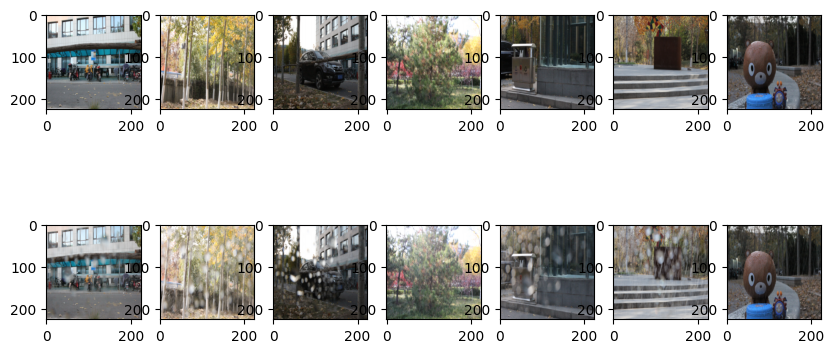

In [13]:
# files_list = glob("//kaggle/input/rainds/RainDS/RainDS_real/train_set/gt/*.png")
# print(len(files_list))
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

for batch in train_dl:
    batch_GT, batch_rain = batch["img_GT"], batch["img_rain"]
    print(batch_GT.max(), batch_GT.min())
    print(batch["img_GT"].shape, batch["img_rain"].shape)
    batch_GT = denormalize(batch_GT, *stats)
    batch_rain = denormalize(batch_rain, *stats)
    img_GT, img_rain = batch_GT[0].permute(1,2,0), batch_rain[0].permute(1,2,0)
    f, axarr = plt.subplots(2,7, figsize = (10,5))
    for i in range(7):
        axarr[0,i].imshow(batch_GT[i].permute(1,2,0))
        axarr[1,i].imshow(batch_rain[i].permute(1,2,0),)
#     f.tickparams(left = False, bottom = False)
    break

In [14]:
# files_list = glob("/kaggle/input/gt-rain/GT-RAIN_train-001/GT-RAIN_train/**/*.png")
# print(len(files_list))

In [15]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [16]:
# model = UNet(num_classes = 3)
# dummy_input = torch.rand(batch_GT.size())
# out = model(dummy_input)
# print(dummy_input.size(), out.size())

In [ ]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)  # Ensure spawn method for multiprocessing

from accelerate import notebook_launcher
from accelerate import Accelerator
import torch
import time
from datetime import timedelta
from tqdm import tqdm
import wandb
from torchmetrics.functional import peak_signal_noise_ratio as compute_psnr
from torchmetrics.functional import structural_similarity_index_measure as compute_ssim
# import piq

EPS = 1e-8

def compute_mse(input, target):
    return torch.mean((input - target) ** 2, dim=[1, 2, 3])

def training_loop(num_epochs: int = 2, 
                  mixed_precision: str = 'fp16', 
                  seed: int = 42, 
                  batch_size: int = 16):
    """
    Unified training and evaluation loop using Accelerate for multi-GPU training.
    """
    # Set the seed for reproducibility
    set_seed(seed)

    # Initialize Accelerator
    accelerator = Accelerator(mixed_precision=mixed_precision)
    
    # Initialize loss, optimizer, dataloaders, and model
    criterion = torch.nn.MSELoss()
    train_dl, valid_dl, test_dl = get_dataloaders(batch_size=batch_size)
    
    with accelerator.main_process_first():
        model = UNet(num_classes=3)
        model_ssl_weights  = torch.load("ssl_model_wts.pt")
        model.load_state_dict(model_ssl_weights, strict=False)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)
    
    # Prepare model, optimizer, and dataloaders with Accelerator
    model, optimizer, train_dl, valid_dl = accelerator.prepare(
        model, optimizer, train_dl, valid_dl
    )
    
    best_val_loss = float('inf')
    epoch_of_interest = None
    train_MSE_list, train_PSNR_list = [], []
    valid_MSE_list, valid_PSNR_list = [], []

    for epoch in range(num_epochs):
        accelerator.print(f"####################### Epoch {epoch:04d} #######################")
        epoch_start_time = time.time()
        
        for phase, dataloader in [("train", train_dl), ("valid", valid_dl)]:
            is_training = phase == "train"
            if is_training:
                model.train()
            else:
                model.eval()

            all_outputs = torch.tensor([]).to(accelerator.device)
            all_targets = torch.tensor([]).to(accelerator.device)

            losses = []
            loop = tqdm(dataloader, disable=not accelerator.is_local_main_process)
            for batch in loop:
                inputs, targets = batch['img_rain'], batch['img_GT']
                
                with torch.set_grad_enabled(is_training):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    if is_training:
                        # Backward pass and optimization
                        accelerator.backward(loss)
                        optimizer.step()
                        optimizer.zero_grad()
                    
                # Gather metrics across devices
                outputs, targets = accelerator.gather_for_metrics((outputs, targets))
                all_outputs = torch.cat((all_outputs, outputs), dim=0)
                all_targets = torch.cat((all_targets, targets), dim=0)
                
                losses.append(loss.item())

            # Compute MSE and PSNR for the entire epoch
            mse = torch.mean(compute_mse(all_outputs, all_targets))
            psnr = torch.mean(compute_psnr(all_outputs, all_targets))
            ssim = torch.mean(compute_ssim(all_outputs, all_targets))
            # niqe = piq.niqe(all_outputs, data_range=1.0).mean()
            # brisque = piq.brisque(all_outputs, data_range=1.0).mean()

            
            avg_loss = sum(losses) / len(losses)
            accelerator.print(f"{phase} Loss: {avg_loss:.4f}, MSE: {mse:.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}")
            
            # Log metrics to WandB
            wandb_run.log({
                f"{phase}_loss": avg_loss,
                f"{phase}_MSE": mse.item(),
                f"{phase}_PSNR": psnr.item(),
                f"{phase}_SSIM": ssim.item(),
                # f"{phase}_NIQE": niqe.item(),
                # # f"{phase}_BRISQUE": brisque.item(),
            })
            
            if not is_training and mse < best_val_loss:
                best_val_loss = mse
                epoch_of_interest = epoch

                # Save the best model
                accelerator.wait_for_everyone()
                unwrapped_model = accelerator.unwrap_model(model)
                accelerator.save(unwrapped_model.state_dict(), f"/kaggle/working/best_model.pt")
            
            # # Append metrics for plotting
            # if is_training:
            #     train_MSE_list.append(mse.item())
            #     train_PSNR_list.append(psnr.item())
            # else:
            #     valid_MSE_list.append(mse.item())
            #     valid_PSNR_list.append(psnr.item())

        epoch_time = time.time() - epoch_start_time
        accelerator.print(f"Epoch completed in {str(timedelta(seconds=epoch_time))}")
        accelerator.print("###########################################################")
    
    # Finalize and save the model
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    accelerator.save(unwrapped_model.state_dict(), f"/kaggle/working/final_model.pt")
    accelerator.print(f"Training complete. Best validation loss: {best_val_loss:.4f} at epoch {epoch_of_interest}")

def main():
    """
    Entry point for notebook_launcher.
    """
    training_loop(
        num_epochs=200, 
        mixed_precision='fp16', 
        seed=42, 
        batch_size=32
    )

# Use notebook_launcher for parallelism
notebook_launcher(main, args=(), num_processes=2)

Launching training on 2 GPUs.


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


150 150 150 150


150it [00:00, 462947.46it/s]
150it [00:00, 648603.71it/s]
150it [00:00, 816012.45it/s]


98 98 98 98


98it [00:00, 706257.37it/s]
98it [00:00, 641250.85it/s]
98it [00:00, 671636.92it/s]


450


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


150 150 150 150


150it [00:00, 656728.18it/s]
150it [00:00, 784470.82it/s]
150it [00:00, 767250.73it/s]


98 98 98 98


98it [00:00, 467624.34it/s]
98it [00:00, 662970.63it/s]
98it [00:00, 679407.92it/s]


450
####################### Epoch 0000 #######################


100%|██████████| 8/8 [01:11<00:00,  8.99s/it]


train Loss: 0.3604, MSE: 0.3686, PSNR: 10.3269, SSIM: 0.2878


100%|██████████| 5/5 [00:46<00:00,  9.37s/it]


valid Loss: 0.2311, MSE: 0.2280, PSNR: 12.4417, SSIM: 0.0002
Epoch completed in 0:02:00.103580
###########################################################
####################### Epoch 0001 #######################


100%|██████████| 8/8 [01:01<00:00,  7.66s/it]


train Loss: 0.2385, MSE: 0.2448, PSNR: 12.1032, SSIM: 0.4099


100%|██████████| 5/5 [00:35<00:00,  7.16s/it]


valid Loss: 0.2139, MSE: 0.2116, PSNR: 12.7651, SSIM: 0.0245
Epoch completed in 0:01:37.826888
###########################################################
####################### Epoch 0002 #######################


100%|██████████| 8/8 [01:00<00:00,  7.60s/it]


train Loss: 0.1954, MSE: 0.1931, PSNR: 13.1338, SSIM: 0.4269


100%|██████████| 5/5 [00:35<00:00,  7.14s/it]


valid Loss: 0.1800, MSE: 0.1802, PSNR: 13.4626, SSIM: 0.0699
Epoch completed in 0:01:37.276129
###########################################################
####################### Epoch 0003 #######################


100%|██████████| 8/8 [01:01<00:00,  7.63s/it]


train Loss: 0.1531, MSE: 0.1593, PSNR: 13.9701, SSIM: 0.4104


100%|██████████| 5/5 [00:36<00:00,  7.25s/it]


valid Loss: 0.1406, MSE: 0.1456, PSNR: 14.3900, SSIM: 0.1526
Epoch completed in 0:01:38.040995
###########################################################
####################### Epoch 0004 #######################


100%|██████████| 8/8 [00:59<00:00,  7.43s/it]


train Loss: 0.1366, MSE: 0.1377, PSNR: 14.6023, SSIM: 0.4520


100%|██████████| 5/5 [00:34<00:00,  6.92s/it]


valid Loss: 0.1220, MSE: 0.1314, PSNR: 14.8355, SSIM: 0.2316
Epoch completed in 0:01:34.790171
###########################################################
####################### Epoch 0005 #######################


100%|██████████| 8/8 [00:59<00:00,  7.39s/it]


train Loss: 0.1134, MSE: 0.1215, PSNR: 15.1462, SSIM: 0.4389


100%|██████████| 5/5 [00:35<00:00,  7.07s/it]


valid Loss: 0.1157, MSE: 0.1281, PSNR: 14.9459, SSIM: 0.2724
Epoch completed in 0:01:35.219771
###########################################################
####################### Epoch 0006 #######################


100%|██████████| 8/8 [00:59<00:00,  7.45s/it]


train Loss: 0.1059, MSE: 0.1105, PSNR: 15.5590, SSIM: 0.4422


100%|██████████| 5/5 [00:35<00:00,  7.09s/it]


valid Loss: 0.1060, MSE: 0.1206, PSNR: 15.2064, SSIM: 0.3266
Epoch completed in 0:01:35.822146
###########################################################
####################### Epoch 0007 #######################


100%|██████████| 8/8 [00:58<00:00,  7.37s/it]


train Loss: 0.1044, MSE: 0.1038, PSNR: 15.8317, SSIM: 0.4231


100%|██████████| 5/5 [00:35<00:00,  7.18s/it]


valid Loss: 0.1148, MSE: 0.1301, PSNR: 14.8762, SSIM: 0.3058
Epoch completed in 0:01:35.373789
###########################################################
####################### Epoch 0008 #######################


100%|██████████| 8/8 [00:59<00:00,  7.43s/it]


train Loss: 0.0936, MSE: 0.0965, PSNR: 16.1446, SSIM: 0.4184


100%|██████████| 5/5 [00:35<00:00,  7.03s/it]


valid Loss: 0.1072, MSE: 0.1235, PSNR: 15.1026, SSIM: 0.3842
Epoch completed in 0:01:35.089508
###########################################################
####################### Epoch 0009 #######################


100%|██████████| 8/8 [00:59<00:00,  7.39s/it]


train Loss: 0.0984, MSE: 0.0913, PSNR: 16.3878, SSIM: 0.4350


100%|██████████| 5/5 [00:34<00:00,  6.95s/it]


valid Loss: 0.1043, MSE: 0.1206, PSNR: 15.2054, SSIM: 0.3405
Epoch completed in 0:01:34.335554
###########################################################
####################### Epoch 0010 #######################


100%|██████████| 8/8 [00:59<00:00,  7.44s/it]


train Loss: 0.0905, MSE: 0.0873, PSNR: 16.5812, SSIM: 0.4425


100%|██████████| 5/5 [00:35<00:00,  7.17s/it]


valid Loss: 0.1115, MSE: 0.1288, PSNR: 14.9229, SSIM: 0.3483
Epoch completed in 0:01:35.835287
###########################################################
####################### Epoch 0011 #######################


100%|██████████| 8/8 [00:59<00:00,  7.43s/it]


train Loss: 0.0879, MSE: 0.0834, PSNR: 16.7829, SSIM: 0.4437


100%|██████████| 5/5 [00:35<00:00,  7.10s/it]


valid Loss: 0.1057, MSE: 0.1224, PSNR: 15.1410, SSIM: 0.3413
Epoch completed in 0:01:35.384736
###########################################################
####################### Epoch 0012 #######################


100%|██████████| 8/8 [00:59<00:00,  7.50s/it]


train Loss: 0.0808, MSE: 0.0803, PSNR: 16.9461, SSIM: 0.4555


100%|██████████| 5/5 [00:35<00:00,  7.00s/it]


valid Loss: 0.1037, MSE: 0.1199, PSNR: 15.2310, SSIM: 0.3765
Epoch completed in 0:01:35.779089
###########################################################
####################### Epoch 0013 #######################


100%|██████████| 8/8 [00:59<00:00,  7.46s/it]


train Loss: 0.0715, MSE: 0.0774, PSNR: 17.1071, SSIM: 0.4467


100%|██████████| 5/5 [00:35<00:00,  7.10s/it]


valid Loss: 0.0983, MSE: 0.1145, PSNR: 15.4341, SSIM: 0.3752
Epoch completed in 0:01:35.952046
###########################################################
####################### Epoch 0014 #######################


100%|██████████| 8/8 [00:59<00:00,  7.40s/it]


train Loss: 0.0755, MSE: 0.0755, PSNR: 17.2143, SSIM: 0.4395


100%|██████████| 5/5 [00:35<00:00,  7.02s/it]


valid Loss: 0.0974, MSE: 0.1149, PSNR: 15.4154, SSIM: 0.3776
Epoch completed in 0:01:34.750515
###########################################################
####################### Epoch 0015 #######################


100%|██████████| 8/8 [00:58<00:00,  7.37s/it]


train Loss: 0.0682, MSE: 0.0727, PSNR: 17.3783, SSIM: 0.4471


100%|██████████| 5/5 [00:35<00:00,  7.08s/it]


valid Loss: 0.0963, MSE: 0.1138, PSNR: 15.4593, SSIM: 0.3823
Epoch completed in 0:01:35.118379
###########################################################
####################### Epoch 0016 #######################


100%|██████████| 8/8 [00:58<00:00,  7.34s/it]


train Loss: 0.0726, MSE: 0.0706, PSNR: 17.5048, SSIM: 0.4703


100%|██████████| 5/5 [00:35<00:00,  7.20s/it]


valid Loss: 0.1007, MSE: 0.1174, PSNR: 15.3242, SSIM: 0.3614
Epoch completed in 0:01:35.141885
###########################################################
####################### Epoch 0017 #######################


100%|██████████| 8/8 [00:59<00:00,  7.46s/it]


train Loss: 0.0685, MSE: 0.0704, PSNR: 17.5151, SSIM: 0.4601


100%|██████████| 5/5 [00:34<00:00,  6.99s/it]


valid Loss: 0.0943, MSE: 0.1108, PSNR: 15.5731, SSIM: 0.3784
Epoch completed in 0:01:35.551902
###########################################################
####################### Epoch 0018 #######################


100%|██████████| 8/8 [00:59<00:00,  7.46s/it]


train Loss: 0.0678, MSE: 0.0680, PSNR: 17.6664, SSIM: 0.4542


100%|██████████| 5/5 [00:34<00:00,  7.00s/it]


valid Loss: 0.0984, MSE: 0.1162, PSNR: 15.3697, SSIM: 0.3791
Epoch completed in 0:01:35.091102
###########################################################
####################### Epoch 0019 #######################


100%|██████████| 8/8 [00:59<00:00,  7.39s/it]


train Loss: 0.0686, MSE: 0.0655, PSNR: 17.8263, SSIM: 0.4606


100%|██████████| 5/5 [00:35<00:00,  7.07s/it]


valid Loss: 0.0904, MSE: 0.1071, PSNR: 15.7225, SSIM: 0.3954
Epoch completed in 0:01:35.202573
###########################################################
####################### Epoch 0020 #######################


100%|██████████| 8/8 [00:59<00:00,  7.40s/it]


train Loss: 0.0608, MSE: 0.0640, PSNR: 17.9282, SSIM: 0.4575


100%|██████████| 5/5 [00:35<00:00,  7.08s/it]


valid Loss: 0.0868, MSE: 0.1044, PSNR: 15.8326, SSIM: 0.3968
Epoch completed in 0:01:35.365394
###########################################################
####################### Epoch 0021 #######################


100%|██████████| 8/8 [00:59<00:00,  7.46s/it]


train Loss: 0.0634, MSE: 0.0634, PSNR: 17.9694, SSIM: 0.4728


100%|██████████| 5/5 [00:35<00:00,  7.01s/it]


valid Loss: 0.0913, MSE: 0.1086, PSNR: 15.6602, SSIM: 0.3923
Epoch completed in 0:01:35.229280
###########################################################
####################### Epoch 0022 #######################


100%|██████████| 8/8 [00:59<00:00,  7.48s/it]


train Loss: 0.0585, MSE: 0.0627, PSNR: 18.0175, SSIM: 0.4737


100%|██████████| 5/5 [00:37<00:00,  7.44s/it]


valid Loss: 0.0914, MSE: 0.1089, PSNR: 15.6503, SSIM: 0.3955
Epoch completed in 0:01:37.498590
###########################################################
####################### Epoch 0023 #######################


100%|██████████| 8/8 [01:02<00:00,  7.79s/it]


train Loss: 0.0634, MSE: 0.0612, PSNR: 18.1221, SSIM: 0.4583


100%|██████████| 5/5 [00:35<00:00,  7.13s/it]


valid Loss: 0.0890, MSE: 0.1071, PSNR: 15.7210, SSIM: 0.3776
Epoch completed in 0:01:38.412909
###########################################################
####################### Epoch 0024 #######################


100%|██████████| 8/8 [01:01<00:00,  7.64s/it]


train Loss: 0.0555, MSE: 0.0595, PSNR: 18.2461, SSIM: 0.4756


100%|██████████| 5/5 [00:35<00:00,  7.14s/it]


valid Loss: 0.0831, MSE: 0.1010, PSNR: 15.9763, SSIM: 0.4081
Epoch completed in 0:01:37.579104
###########################################################
####################### Epoch 0025 #######################


100%|██████████| 8/8 [01:00<00:00,  7.56s/it]


train Loss: 0.0630, MSE: 0.0604, PSNR: 18.1789, SSIM: 0.4782


100%|██████████| 5/5 [00:35<00:00,  7.07s/it]


valid Loss: 0.0822, MSE: 0.0994, PSNR: 16.0467, SSIM: 0.3940
Epoch completed in 0:01:36.598639
###########################################################
####################### Epoch 0026 #######################


100%|██████████| 8/8 [01:00<00:00,  7.59s/it]


train Loss: 0.0681, MSE: 0.0594, PSNR: 18.2572, SSIM: 0.4697


100%|██████████| 5/5 [00:35<00:00,  7.04s/it]


valid Loss: 0.0895, MSE: 0.1072, PSNR: 15.7184, SSIM: 0.3736
Epoch completed in 0:01:36.384843
###########################################################
####################### Epoch 0027 #######################


100%|██████████| 8/8 [00:58<00:00,  7.37s/it]


train Loss: 0.0639, MSE: 0.0576, PSNR: 18.3910, SSIM: 0.4859


100%|██████████| 5/5 [00:36<00:00,  7.28s/it]


valid Loss: 0.0886, MSE: 0.1065, PSNR: 15.7484, SSIM: 0.3744
Epoch completed in 0:01:35.807539
###########################################################
####################### Epoch 0028 #######################


100%|██████████| 8/8 [01:03<00:00,  7.88s/it]


train Loss: 0.0578, MSE: 0.0557, PSNR: 18.5302, SSIM: 0.4808


100%|██████████| 5/5 [00:37<00:00,  7.43s/it]


valid Loss: 0.0881, MSE: 0.1056, PSNR: 15.7844, SSIM: 0.3759
Epoch completed in 0:01:40.637275
###########################################################
####################### Epoch 0029 #######################


100%|██████████| 8/8 [01:02<00:00,  7.83s/it]


train Loss: 0.0571, MSE: 0.0549, PSNR: 18.5930, SSIM: 0.4777


100%|██████████| 5/5 [00:36<00:00,  7.40s/it]


valid Loss: 0.0874, MSE: 0.1055, PSNR: 15.7890, SSIM: 0.3822
Epoch completed in 0:01:40.041927
###########################################################
####################### Epoch 0030 #######################


100%|██████████| 8/8 [01:01<00:00,  7.72s/it]


train Loss: 0.0554, MSE: 0.0534, PSNR: 18.7147, SSIM: 0.4959


100%|██████████| 5/5 [00:36<00:00,  7.39s/it]


valid Loss: 0.0836, MSE: 0.1011, PSNR: 15.9718, SSIM: 0.4118
Epoch completed in 0:01:39.151002
###########################################################
####################### Epoch 0031 #######################


100%|██████████| 8/8 [01:01<00:00,  7.71s/it]


train Loss: 0.0480, MSE: 0.0532, PSNR: 18.7301, SSIM: 0.4960


100%|██████████| 5/5 [00:36<00:00,  7.30s/it]


valid Loss: 0.0789, MSE: 0.0970, PSNR: 16.1512, SSIM: 0.4205
Epoch completed in 0:01:39.017235
###########################################################
####################### Epoch 0032 #######################


100%|██████████| 8/8 [01:01<00:00,  7.74s/it]


train Loss: 0.0492, MSE: 0.0519, PSNR: 18.8404, SSIM: 0.5023


100%|██████████| 5/5 [00:36<00:00,  7.38s/it]


valid Loss: 0.0770, MSE: 0.0957, PSNR: 16.2100, SSIM: 0.4228
Epoch completed in 0:01:39.534993
###########################################################
####################### Epoch 0033 #######################


100%|██████████| 8/8 [01:01<00:00,  7.68s/it]


train Loss: 0.0527, MSE: 0.0514, PSNR: 18.8837, SSIM: 0.4869


100%|██████████| 5/5 [00:36<00:00,  7.37s/it]


valid Loss: 0.0782, MSE: 0.0969, PSNR: 16.1577, SSIM: 0.4129
Epoch completed in 0:01:38.762177
###########################################################
####################### Epoch 0034 #######################


100%|██████████| 8/8 [01:01<00:00,  7.65s/it]


train Loss: 0.0516, MSE: 0.0496, PSNR: 19.0391, SSIM: 0.4960


100%|██████████| 5/5 [00:38<00:00,  7.64s/it]


valid Loss: 0.0808, MSE: 0.0986, PSNR: 16.0835, SSIM: 0.4197
Epoch completed in 0:01:39.798638
###########################################################
####################### Epoch 0035 #######################


100%|██████████| 8/8 [01:02<00:00,  7.87s/it]


train Loss: 0.0603, MSE: 0.0510, PSNR: 18.9160, SSIM: 0.5060


100%|██████████| 5/5 [00:36<00:00,  7.33s/it]


valid Loss: 0.0933, MSE: 0.1112, PSNR: 15.5587, SSIM: 0.3726
Epoch completed in 0:01:40.051433
###########################################################
####################### Epoch 0036 #######################


100%|██████████| 8/8 [01:01<00:00,  7.71s/it]


train Loss: 0.0451, MSE: 0.0484, PSNR: 19.1458, SSIM: 0.5062


100%|██████████| 5/5 [00:36<00:00,  7.31s/it]


valid Loss: 0.0778, MSE: 0.0967, PSNR: 16.1659, SSIM: 0.4053
Epoch completed in 0:01:38.667835
###########################################################
####################### Epoch 0037 #######################


100%|██████████| 8/8 [01:01<00:00,  7.69s/it]


train Loss: 0.0458, MSE: 0.0477, PSNR: 19.2060, SSIM: 0.5144


100%|██████████| 5/5 [00:36<00:00,  7.38s/it]


valid Loss: 0.0732, MSE: 0.0921, PSNR: 16.3759, SSIM: 0.4175
Epoch completed in 0:01:39.198677
###########################################################
####################### Epoch 0038 #######################


100%|██████████| 8/8 [01:01<00:00,  7.71s/it]


train Loss: 0.0478, MSE: 0.0470, PSNR: 19.2672, SSIM: 0.5383


100%|██████████| 5/5 [00:36<00:00,  7.29s/it]


valid Loss: 0.0751, MSE: 0.0942, PSNR: 16.2815, SSIM: 0.4254
Epoch completed in 0:01:38.534690
###########################################################
####################### Epoch 0039 #######################


100%|██████████| 8/8 [01:01<00:00,  7.67s/it]


train Loss: 0.0498, MSE: 0.0459, PSNR: 19.3785, SSIM: 0.5111


100%|██████████| 5/5 [00:37<00:00,  7.46s/it]


valid Loss: 0.0775, MSE: 0.0954, PSNR: 16.2240, SSIM: 0.4072
Epoch completed in 0:01:39.104799
###########################################################
####################### Epoch 0040 #######################


100%|██████████| 8/8 [01:00<00:00,  7.56s/it]


train Loss: 0.0498, MSE: 0.0449, PSNR: 19.4684, SSIM: 0.5296


100%|██████████| 5/5 [00:35<00:00,  7.14s/it]


valid Loss: 0.0765, MSE: 0.0949, PSNR: 16.2496, SSIM: 0.4072
Epoch completed in 0:01:36.661547
###########################################################
####################### Epoch 0041 #######################


100%|██████████| 8/8 [00:59<00:00,  7.42s/it]


train Loss: 0.0459, MSE: 0.0443, PSNR: 19.5300, SSIM: 0.5313


100%|██████████| 5/5 [00:38<00:00,  7.64s/it]


valid Loss: 0.0752, MSE: 0.0941, PSNR: 16.2866, SSIM: 0.4076
Epoch completed in 0:01:37.973505
###########################################################
####################### Epoch 0042 #######################


100%|██████████| 8/8 [01:04<00:00,  8.01s/it]


train Loss: 0.0425, MSE: 0.0437, PSNR: 19.5901, SSIM: 0.5491


100%|██████████| 5/5 [00:38<00:00,  7.69s/it]


valid Loss: 0.0728, MSE: 0.0908, PSNR: 16.4417, SSIM: 0.4232
Epoch completed in 0:01:43.343104
###########################################################
####################### Epoch 0043 #######################


100%|██████████| 8/8 [01:05<00:00,  8.20s/it]


train Loss: 0.0470, MSE: 0.0435, PSNR: 19.6084, SSIM: 0.5347


100%|██████████| 5/5 [00:37<00:00,  7.54s/it]


valid Loss: 0.0723, MSE: 0.0909, PSNR: 16.4330, SSIM: 0.4258
Epoch completed in 0:01:43.753669
###########################################################
####################### Epoch 0044 #######################


100%|██████████| 8/8 [01:02<00:00,  7.76s/it]


train Loss: 0.0479, MSE: 0.0428, PSNR: 19.6731, SSIM: 0.5448


100%|██████████| 5/5 [00:36<00:00,  7.27s/it]


valid Loss: 0.0742, MSE: 0.0927, PSNR: 16.3484, SSIM: 0.4260
Epoch completed in 0:01:38.925626
###########################################################
####################### Epoch 0045 #######################


100%|██████████| 8/8 [01:00<00:00,  7.58s/it]


train Loss: 0.0466, MSE: 0.0412, PSNR: 19.8473, SSIM: 0.5434


100%|██████████| 5/5 [00:36<00:00,  7.30s/it]


valid Loss: 0.0775, MSE: 0.0955, PSNR: 16.2207, SSIM: 0.4112
Epoch completed in 0:01:37.592390
###########################################################
####################### Epoch 0046 #######################


100%|██████████| 8/8 [01:00<00:00,  7.60s/it]


train Loss: 0.0411, MSE: 0.0403, PSNR: 19.9417, SSIM: 0.5547


100%|██████████| 5/5 [00:36<00:00,  7.31s/it]


valid Loss: 0.0728, MSE: 0.0915, PSNR: 16.4075, SSIM: 0.4160
Epoch completed in 0:01:37.805311
###########################################################
####################### Epoch 0047 #######################


100%|██████████| 8/8 [01:01<00:00,  7.63s/it]


train Loss: 0.0461, MSE: 0.0399, PSNR: 19.9812, SSIM: 0.5441


100%|██████████| 5/5 [00:36<00:00,  7.24s/it]


valid Loss: 0.0713, MSE: 0.0903, PSNR: 16.4648, SSIM: 0.4119
Epoch completed in 0:01:37.996936
###########################################################
####################### Epoch 0048 #######################


100%|██████████| 8/8 [01:00<00:00,  7.59s/it]


train Loss: 0.0356, MSE: 0.0393, PSNR: 20.0513, SSIM: 0.5577


100%|██████████| 5/5 [00:35<00:00,  7.18s/it]


valid Loss: 0.0646, MSE: 0.0836, PSNR: 16.7980, SSIM: 0.4423
Epoch completed in 0:01:37.432908
###########################################################
####################### Epoch 0049 #######################


100%|██████████| 8/8 [01:00<00:00,  7.62s/it]


train Loss: 0.0378, MSE: 0.0384, PSNR: 20.1447, SSIM: 0.5561


100%|██████████| 5/5 [00:35<00:00,  7.18s/it]


valid Loss: 0.0654, MSE: 0.0846, PSNR: 16.7485, SSIM: 0.4527
Epoch completed in 0:01:37.323007
###########################################################
####################### Epoch 0050 #######################


100%|██████████| 8/8 [01:00<00:00,  7.58s/it]


train Loss: 0.0342, MSE: 0.0374, PSNR: 20.2588, SSIM: 0.5685


100%|██████████| 5/5 [00:36<00:00,  7.25s/it]


valid Loss: 0.0635, MSE: 0.0824, PSNR: 16.8630, SSIM: 0.4782
Epoch completed in 0:01:37.695838
###########################################################
####################### Epoch 0051 #######################


100%|██████████| 8/8 [01:01<00:00,  7.68s/it]


train Loss: 0.0389, MSE: 0.0373, PSNR: 20.2804, SSIM: 0.5655


100%|██████████| 5/5 [00:36<00:00,  7.22s/it]


valid Loss: 0.0617, MSE: 0.0815, PSNR: 16.9077, SSIM: 0.4761
Epoch completed in 0:01:38.238026
###########################################################
####################### Epoch 0052 #######################


100%|██████████| 8/8 [01:00<00:00,  7.62s/it]


train Loss: 0.0346, MSE: 0.0360, PSNR: 20.4339, SSIM: 0.5896


100%|██████████| 5/5 [00:35<00:00,  7.17s/it]


valid Loss: 0.0627, MSE: 0.0821, PSNR: 16.8756, SSIM: 0.4589
Epoch completed in 0:01:37.292497
###########################################################
####################### Epoch 0053 #######################


100%|██████████| 8/8 [01:00<00:00,  7.61s/it]


train Loss: 0.0334, MSE: 0.0351, PSNR: 20.5351, SSIM: 0.5717


100%|██████████| 5/5 [00:36<00:00,  7.21s/it]


valid Loss: 0.0620, MSE: 0.0818, PSNR: 16.8915, SSIM: 0.4868
Epoch completed in 0:01:37.415406
###########################################################
####################### Epoch 0054 #######################


100%|██████████| 8/8 [01:01<00:00,  7.74s/it]


train Loss: 0.0338, MSE: 0.0343, PSNR: 20.6380, SSIM: 0.5883


100%|██████████| 5/5 [00:37<00:00,  7.45s/it]


valid Loss: 0.0634, MSE: 0.0836, PSNR: 16.7991, SSIM: 0.4834
Epoch completed in 0:01:39.648226
###########################################################
####################### Epoch 0055 #######################


100%|██████████| 8/8 [01:00<00:00,  7.61s/it]


train Loss: 0.0368, MSE: 0.0338, PSNR: 20.7054, SSIM: 0.5889


100%|██████████| 5/5 [00:36<00:00,  7.23s/it]


valid Loss: 0.0637, MSE: 0.0830, PSNR: 16.8271, SSIM: 0.4702
Epoch completed in 0:01:37.529860
###########################################################
####################### Epoch 0056 #######################


100%|██████████| 8/8 [01:00<00:00,  7.59s/it]


train Loss: 0.0328, MSE: 0.0324, PSNR: 20.8806, SSIM: 0.5967


100%|██████████| 5/5 [00:35<00:00,  7.16s/it]


valid Loss: 0.0623, MSE: 0.0817, PSNR: 16.8957, SSIM: 0.4760
Epoch completed in 0:01:36.992556
###########################################################
####################### Epoch 0057 #######################


100%|██████████| 8/8 [01:00<00:00,  7.62s/it]


train Loss: 0.0315, MSE: 0.0324, PSNR: 20.8874, SSIM: 0.6007


100%|██████████| 5/5 [00:36<00:00,  7.35s/it]


valid Loss: 0.0605, MSE: 0.0795, PSNR: 17.0182, SSIM: 0.4640
Epoch completed in 0:01:38.464289
###########################################################
####################### Epoch 0058 #######################


100%|██████████| 8/8 [01:00<00:00,  7.60s/it]


train Loss: 0.0287, MSE: 0.0316, PSNR: 20.9961, SSIM: 0.6105


100%|██████████| 5/5 [00:36<00:00,  7.32s/it]


valid Loss: 0.0582, MSE: 0.0780, PSNR: 17.0988, SSIM: 0.4793
Epoch completed in 0:01:38.258014
###########################################################
####################### Epoch 0059 #######################


100%|██████████| 8/8 [01:00<00:00,  7.51s/it]


train Loss: 0.0294, MSE: 0.0300, PSNR: 21.2162, SSIM: 0.5965


100%|██████████| 5/5 [00:37<00:00,  7.56s/it]


valid Loss: 0.0572, MSE: 0.0772, PSNR: 17.1430, SSIM: 0.4976
Epoch completed in 0:01:38.681175
###########################################################
####################### Epoch 0060 #######################


100%|██████████| 8/8 [01:01<00:00,  7.70s/it]


train Loss: 0.0267, MSE: 0.0302, PSNR: 21.1896, SSIM: 0.6302


100%|██████████| 5/5 [00:37<00:00,  7.48s/it]


valid Loss: 0.0530, MSE: 0.0731, PSNR: 17.3784, SSIM: 0.4967
Epoch completed in 0:01:39.727329
###########################################################
####################### Epoch 0061 #######################


100%|██████████| 8/8 [01:02<00:00,  7.82s/it]


train Loss: 0.0284, MSE: 0.0297, PSNR: 21.2628, SSIM: 0.6128


100%|██████████| 5/5 [00:36<00:00,  7.28s/it]


valid Loss: 0.0536, MSE: 0.0737, PSNR: 17.3478, SSIM: 0.5084
Epoch completed in 0:01:39.430887
###########################################################
####################### Epoch 0062 #######################


100%|██████████| 8/8 [01:01<00:00,  7.75s/it]


train Loss: 0.0277, MSE: 0.0283, PSNR: 21.4675, SSIM: 0.6211


100%|██████████| 5/5 [00:36<00:00,  7.35s/it]


valid Loss: 0.0533, MSE: 0.0732, PSNR: 17.3744, SSIM: 0.5074
Epoch completed in 0:01:39.209141
###########################################################
####################### Epoch 0063 #######################


100%|██████████| 8/8 [01:02<00:00,  7.79s/it]


train Loss: 0.0284, MSE: 0.0279, PSNR: 21.5380, SSIM: 0.6257


100%|██████████| 5/5 [00:36<00:00,  7.39s/it]


valid Loss: 0.0564, MSE: 0.0758, PSNR: 17.2253, SSIM: 0.5061
Epoch completed in 0:01:39.753812
###########################################################
####################### Epoch 0064 #######################


100%|██████████| 8/8 [01:01<00:00,  7.74s/it]


train Loss: 0.0234, MSE: 0.0269, PSNR: 21.6919, SSIM: 0.6276


100%|██████████| 5/5 [00:36<00:00,  7.36s/it]


valid Loss: 0.0500, MSE: 0.0702, PSNR: 17.5579, SSIM: 0.5196
Epoch completed in 0:01:39.579101
###########################################################
####################### Epoch 0065 #######################


100%|██████████| 8/8 [01:02<00:00,  7.86s/it]


train Loss: 0.0247, MSE: 0.0260, PSNR: 21.8493, SSIM: 0.6375


100%|██████████| 5/5 [00:38<00:00,  7.69s/it]


valid Loss: 0.0497, MSE: 0.0703, PSNR: 17.5507, SSIM: 0.5148
Epoch completed in 0:01:41.763328
###########################################################
####################### Epoch 0066 #######################


100%|██████████| 8/8 [01:02<00:00,  7.86s/it]


train Loss: 0.0251, MSE: 0.0257, PSNR: 21.8950, SSIM: 0.6447


100%|██████████| 5/5 [00:37<00:00,  7.40s/it]


valid Loss: 0.0521, MSE: 0.0722, PSNR: 17.4350, SSIM: 0.5140
Epoch completed in 0:01:40.329026
###########################################################
####################### Epoch 0067 #######################


100%|██████████| 8/8 [01:01<00:00,  7.71s/it]


train Loss: 0.0236, MSE: 0.0243, PSNR: 22.1329, SSIM: 0.6376


100%|██████████| 5/5 [00:36<00:00,  7.31s/it]


valid Loss: 0.0504, MSE: 0.0705, PSNR: 17.5415, SSIM: 0.5187
Epoch completed in 0:01:38.680697
###########################################################
####################### Epoch 0068 #######################


100%|██████████| 8/8 [01:01<00:00,  7.74s/it]


train Loss: 0.0249, MSE: 0.0242, PSNR: 22.1626, SSIM: 0.6460


100%|██████████| 5/5 [00:36<00:00,  7.36s/it]


valid Loss: 0.0492, MSE: 0.0693, PSNR: 17.6144, SSIM: 0.5183
Epoch completed in 0:01:39.454963
###########################################################
####################### Epoch 0069 #######################


100%|██████████| 8/8 [01:02<00:00,  7.82s/it]


train Loss: 0.0260, MSE: 0.0250, PSNR: 22.0202, SSIM: 0.6480


100%|██████████| 5/5 [00:37<00:00,  7.43s/it]


valid Loss: 0.0490, MSE: 0.0688, PSNR: 17.6446, SSIM: 0.5004
Epoch completed in 0:01:40.518780
###########################################################
####################### Epoch 0070 #######################


100%|██████████| 8/8 [01:02<00:00,  7.77s/it]


train Loss: 0.0232, MSE: 0.0233, PSNR: 22.3163, SSIM: 0.6778


100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


valid Loss: 0.0494, MSE: 0.0693, PSNR: 17.6110, SSIM: 0.5326
Epoch completed in 0:01:40.286199
###########################################################
####################### Epoch 0071 #######################


100%|██████████| 8/8 [01:02<00:00,  7.80s/it]


train Loss: 0.0206, MSE: 0.0217, PSNR: 22.6179, SSIM: 0.6718


100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


valid Loss: 0.0501, MSE: 0.0708, PSNR: 17.5216, SSIM: 0.5293
Epoch completed in 0:01:40.523528
###########################################################
####################### Epoch 0072 #######################


100%|██████████| 8/8 [01:01<00:00,  7.72s/it]


train Loss: 0.0221, MSE: 0.0220, PSNR: 22.5699, SSIM: 0.6709


100%|██████████| 5/5 [00:37<00:00,  7.49s/it]


valid Loss: 0.0511, MSE: 0.0720, PSNR: 17.4493, SSIM: 0.5182
Epoch completed in 0:01:39.642744
###########################################################
####################### Epoch 0073 #######################


100%|██████████| 8/8 [01:01<00:00,  7.64s/it]


train Loss: 0.0227, MSE: 0.0209, PSNR: 22.7967, SSIM: 0.6766


100%|██████████| 5/5 [00:36<00:00,  7.38s/it]


valid Loss: 0.0491, MSE: 0.0696, PSNR: 17.5940, SSIM: 0.5236
Epoch completed in 0:01:38.499681
###########################################################
####################### Epoch 0074 #######################


100%|██████████| 8/8 [01:01<00:00,  7.63s/it]


train Loss: 0.0206, MSE: 0.0205, PSNR: 22.8828, SSIM: 0.6866


100%|██████████| 5/5 [00:36<00:00,  7.38s/it]


valid Loss: 0.0483, MSE: 0.0684, PSNR: 17.6719, SSIM: 0.5334
Epoch completed in 0:01:38.723651
###########################################################
####################### Epoch 0075 #######################


100%|██████████| 8/8 [01:01<00:00,  7.66s/it]


train Loss: 0.0208, MSE: 0.0199, PSNR: 23.0038, SSIM: 0.6800


100%|██████████| 5/5 [00:36<00:00,  7.37s/it]


valid Loss: 0.0472, MSE: 0.0678, PSNR: 17.7068, SSIM: 0.5390
Epoch completed in 0:01:38.937834
###########################################################
####################### Epoch 0076 #######################


100%|██████████| 8/8 [01:02<00:00,  7.79s/it]


train Loss: 0.0200, MSE: 0.0200, PSNR: 22.9829, SSIM: 0.6845


100%|██████████| 5/5 [00:37<00:00,  7.43s/it]


valid Loss: 0.0455, MSE: 0.0656, PSNR: 17.8489, SSIM: 0.5324
Epoch completed in 0:01:40.361301
###########################################################
####################### Epoch 0077 #######################


100%|██████████| 8/8 [01:01<00:00,  7.72s/it]


train Loss: 0.0168, MSE: 0.0196, PSNR: 23.0804, SSIM: 0.6898


100%|██████████| 5/5 [00:37<00:00,  7.41s/it]


valid Loss: 0.0435, MSE: 0.0639, PSNR: 17.9684, SSIM: 0.5466
Epoch completed in 0:01:39.541192
###########################################################
####################### Epoch 0078 #######################


100%|██████████| 8/8 [01:01<00:00,  7.72s/it]


train Loss: 0.0173, MSE: 0.0183, PSNR: 23.3667, SSIM: 0.7053


100%|██████████| 5/5 [00:36<00:00,  7.36s/it]


valid Loss: 0.0435, MSE: 0.0646, PSNR: 17.9200, SSIM: 0.5558
Epoch completed in 0:01:39.050682
###########################################################
####################### Epoch 0079 #######################


100%|██████████| 8/8 [01:01<00:00,  7.70s/it]


train Loss: 0.0192, MSE: 0.0181, PSNR: 23.4104, SSIM: 0.7200


100%|██████████| 5/5 [00:36<00:00,  7.30s/it]


valid Loss: 0.0449, MSE: 0.0659, PSNR: 17.8306, SSIM: 0.5601
Epoch completed in 0:01:38.543783
###########################################################
####################### Epoch 0080 #######################


100%|██████████| 8/8 [01:01<00:00,  7.68s/it]


train Loss: 0.0171, MSE: 0.0169, PSNR: 23.7065, SSIM: 0.7040


100%|██████████| 5/5 [00:37<00:00,  7.45s/it]


valid Loss: 0.0434, MSE: 0.0638, PSNR: 17.9692, SSIM: 0.5473
Epoch completed in 0:01:39.455519
###########################################################
####################### Epoch 0081 #######################


100%|██████████| 8/8 [01:02<00:00,  7.78s/it]


train Loss: 0.0214, MSE: 0.0173, PSNR: 23.5998, SSIM: 0.7189


100%|██████████| 5/5 [00:37<00:00,  7.46s/it]


valid Loss: 0.0468, MSE: 0.0669, PSNR: 17.7635, SSIM: 0.5342
Epoch completed in 0:01:40.002171
###########################################################
####################### Epoch 0082 #######################


100%|██████████| 8/8 [01:02<00:00,  7.83s/it]


train Loss: 0.0181, MSE: 0.0168, PSNR: 23.7476, SSIM: 0.7215


100%|██████████| 5/5 [00:36<00:00,  7.24s/it]


valid Loss: 0.0451, MSE: 0.0655, PSNR: 17.8606, SSIM: 0.5457
Epoch completed in 0:01:39.346327
###########################################################
####################### Epoch 0083 #######################


100%|██████████| 8/8 [01:01<00:00,  7.68s/it]


train Loss: 0.0153, MSE: 0.0157, PSNR: 24.0384, SSIM: 0.7390


100%|██████████| 5/5 [00:36<00:00,  7.27s/it]


valid Loss: 0.0423, MSE: 0.0633, PSNR: 18.0052, SSIM: 0.5630
Epoch completed in 0:01:38.621410
###########################################################
####################### Epoch 0084 #######################


100%|██████████| 8/8 [01:01<00:00,  7.67s/it]


train Loss: 0.0149, MSE: 0.0157, PSNR: 24.0298, SSIM: 0.7361


100%|██████████| 5/5 [00:37<00:00,  7.41s/it]


valid Loss: 0.0423, MSE: 0.0633, PSNR: 18.0077, SSIM: 0.5693
Epoch completed in 0:01:39.268998
###########################################################
####################### Epoch 0085 #######################


100%|██████████| 8/8 [01:02<00:00,  7.77s/it]


train Loss: 0.0135, MSE: 0.0150, PSNR: 24.2259, SSIM: 0.7439


100%|██████████| 5/5 [00:36<00:00,  7.38s/it]


valid Loss: 0.0393, MSE: 0.0605, PSNR: 18.2048, SSIM: 0.5953
Epoch completed in 0:01:39.855273
###########################################################
####################### Epoch 0086 #######################


100%|██████████| 8/8 [01:02<00:00,  7.75s/it]


train Loss: 0.0165, MSE: 0.0146, PSNR: 24.3610, SSIM: 0.7357


100%|██████████| 5/5 [00:36<00:00,  7.37s/it]


valid Loss: 0.0406, MSE: 0.0621, PSNR: 18.0877, SSIM: 0.5846
Epoch completed in 0:01:39.331728
###########################################################
####################### Epoch 0087 #######################


100%|██████████| 8/8 [01:02<00:00,  7.82s/it]


train Loss: 0.0130, MSE: 0.0145, PSNR: 24.3655, SSIM: 0.7339


100%|██████████| 5/5 [00:36<00:00,  7.37s/it]


valid Loss: 0.0376, MSE: 0.0594, PSNR: 18.2819, SSIM: 0.5828
Epoch completed in 0:01:40.391615
###########################################################
####################### Epoch 0088 #######################


100%|██████████| 8/8 [01:02<00:00,  7.79s/it]


train Loss: 0.0127, MSE: 0.0137, PSNR: 24.6138, SSIM: 0.7409


100%|██████████| 5/5 [00:37<00:00,  7.41s/it]


valid Loss: 0.0370, MSE: 0.0584, PSNR: 18.3548, SSIM: 0.5797
Epoch completed in 0:01:40.206536
###########################################################
####################### Epoch 0089 #######################


100%|██████████| 8/8 [01:01<00:00,  7.66s/it]


train Loss: 0.0127, MSE: 0.0136, PSNR: 24.6725, SSIM: 0.7408


100%|██████████| 5/5 [00:36<00:00,  7.36s/it]


valid Loss: 0.0365, MSE: 0.0584, PSNR: 18.3597, SSIM: 0.5758
Epoch completed in 0:01:38.971491
###########################################################
####################### Epoch 0090 #######################


100%|██████████| 8/8 [01:02<00:00,  7.77s/it]


train Loss: 0.0126, MSE: 0.0140, PSNR: 24.5345, SSIM: 0.7412


100%|██████████| 5/5 [00:36<00:00,  7.25s/it]


valid Loss: 0.0364, MSE: 0.0576, PSNR: 18.4158, SSIM: 0.5771
Epoch completed in 0:01:39.139851
###########################################################
####################### Epoch 0091 #######################


100%|██████████| 8/8 [01:01<00:00,  7.71s/it]


train Loss: 0.0135, MSE: 0.0130, PSNR: 24.8660, SSIM: 0.7472


100%|██████████| 5/5 [00:36<00:00,  7.32s/it]


valid Loss: 0.0379, MSE: 0.0591, PSNR: 18.3065, SSIM: 0.5929
Epoch completed in 0:01:38.720253
###########################################################
####################### Epoch 0092 #######################


100%|██████████| 8/8 [01:02<00:00,  7.85s/it]


train Loss: 0.0133, MSE: 0.0130, PSNR: 24.8570, SSIM: 0.7568


100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


valid Loss: 0.0378, MSE: 0.0592, PSNR: 18.2961, SSIM: 0.5822
Epoch completed in 0:01:40.929898
###########################################################
####################### Epoch 0093 #######################


100%|██████████| 8/8 [01:02<00:00,  7.84s/it]


train Loss: 0.0127, MSE: 0.0130, PSNR: 24.8519, SSIM: 0.7573


100%|██████████| 5/5 [00:37<00:00,  7.48s/it]


valid Loss: 0.0355, MSE: 0.0575, PSNR: 18.4243, SSIM: 0.5892
Epoch completed in 0:01:40.865294
###########################################################
####################### Epoch 0094 #######################


100%|██████████| 8/8 [01:03<00:00,  7.89s/it]


train Loss: 0.0109, MSE: 0.0119, PSNR: 25.2404, SSIM: 0.7668


100%|██████████| 5/5 [00:37<00:00,  7.57s/it]


valid Loss: 0.0367, MSE: 0.0589, PSNR: 18.3200, SSIM: 0.6156
Epoch completed in 0:01:41.397831
###########################################################
####################### Epoch 0095 #######################


100%|██████████| 8/8 [01:01<00:00,  7.65s/it]


train Loss: 0.0136, MSE: 0.0117, PSNR: 25.2985, SSIM: 0.7802


100%|██████████| 5/5 [00:36<00:00,  7.26s/it]


valid Loss: 0.0357, MSE: 0.0574, PSNR: 18.4344, SSIM: 0.6095
Epoch completed in 0:01:38.288292
###########################################################
####################### Epoch 0096 #######################


100%|██████████| 8/8 [01:00<00:00,  7.62s/it]


train Loss: 0.0115, MSE: 0.0119, PSNR: 25.2486, SSIM: 0.7826


100%|██████████| 5/5 [00:35<00:00,  7.10s/it]


valid Loss: 0.0366, MSE: 0.0579, PSNR: 18.3924, SSIM: 0.5798
Epoch completed in 0:01:36.941851
###########################################################
####################### Epoch 0097 #######################


100%|██████████| 8/8 [00:59<00:00,  7.47s/it]


train Loss: 0.0133, MSE: 0.0127, PSNR: 24.9508, SSIM: 0.7564


100%|██████████| 5/5 [00:35<00:00,  7.11s/it]


valid Loss: 0.0398, MSE: 0.0610, PSNR: 18.1649, SSIM: 0.5695
Epoch completed in 0:01:35.735967
###########################################################
####################### Epoch 0098 #######################


100%|██████████| 8/8 [00:59<00:00,  7.43s/it]


train Loss: 0.0113, MSE: 0.0120, PSNR: 25.1975, SSIM: 0.7590


100%|██████████| 5/5 [00:35<00:00,  7.15s/it]


valid Loss: 0.0375, MSE: 0.0590, PSNR: 18.3137, SSIM: 0.5996
Epoch completed in 0:01:35.663859
###########################################################
####################### Epoch 0099 #######################


100%|██████████| 8/8 [00:59<00:00,  7.49s/it]


train Loss: 0.0106, MSE: 0.0121, PSNR: 25.1706, SSIM: 0.7628


100%|██████████| 5/5 [00:35<00:00,  7.04s/it]


valid Loss: 0.0342, MSE: 0.0562, PSNR: 18.5263, SSIM: 0.5928
Epoch completed in 0:01:35.896858
###########################################################
####################### Epoch 0100 #######################


100%|██████████| 8/8 [00:59<00:00,  7.48s/it]


train Loss: 0.0115, MSE: 0.0114, PSNR: 25.4192, SSIM: 0.7816


100%|██████████| 5/5 [00:35<00:00,  7.11s/it]


valid Loss: 0.0346, MSE: 0.0565, PSNR: 18.5028, SSIM: 0.5865
Epoch completed in 0:01:35.881396
###########################################################
####################### Epoch 0101 #######################


100%|██████████| 8/8 [01:00<00:00,  7.60s/it]


train Loss: 0.0108, MSE: 0.0116, PSNR: 25.3532, SSIM: 0.7718


100%|██████████| 5/5 [00:35<00:00,  7.16s/it]


valid Loss: 0.0356, MSE: 0.0569, PSNR: 18.4679, SSIM: 0.5882
Epoch completed in 0:01:37.063313
###########################################################
####################### Epoch 0102 #######################


100%|██████████| 8/8 [01:00<00:00,  7.55s/it]


train Loss: 0.0114, MSE: 0.0107, PSNR: 25.6832, SSIM: 0.7883


100%|██████████| 5/5 [00:35<00:00,  7.13s/it]


valid Loss: 0.0370, MSE: 0.0581, PSNR: 18.3754, SSIM: 0.5857
Epoch completed in 0:01:36.544754
###########################################################
####################### Epoch 0103 #######################


100%|██████████| 8/8 [01:00<00:00,  7.52s/it]


train Loss: 0.0109, MSE: 0.0113, PSNR: 25.4441, SSIM: 0.7840


100%|██████████| 5/5 [00:36<00:00,  7.23s/it]


valid Loss: 0.0358, MSE: 0.0579, PSNR: 18.3953, SSIM: 0.5868
Epoch completed in 0:01:36.804488
###########################################################
####################### Epoch 0104 #######################


100%|██████████| 8/8 [01:02<00:00,  7.77s/it]


train Loss: 0.0114, MSE: 0.0107, PSNR: 25.6820, SSIM: 0.7779


100%|██████████| 5/5 [00:36<00:00,  7.27s/it]


valid Loss: 0.0348, MSE: 0.0568, PSNR: 18.4742, SSIM: 0.5959
Epoch completed in 0:01:38.928544
###########################################################
####################### Epoch 0105 #######################


100%|██████████| 8/8 [01:00<00:00,  7.59s/it]


train Loss: 0.0105, MSE: 0.0105, PSNR: 25.7603, SSIM: 0.7803


100%|██████████| 5/5 [00:35<00:00,  7.18s/it]


valid Loss: 0.0344, MSE: 0.0558, PSNR: 18.5523, SSIM: 0.5963
Epoch completed in 0:01:37.429955
###########################################################
####################### Epoch 0106 #######################


100%|██████████| 8/8 [01:00<00:00,  7.59s/it]


train Loss: 0.0096, MSE: 0.0100, PSNR: 25.9787, SSIM: 0.7970


100%|██████████| 5/5 [00:35<00:00,  7.16s/it]


valid Loss: 0.0329, MSE: 0.0547, PSNR: 18.6368, SSIM: 0.6027
Epoch completed in 0:01:37.270454
###########################################################
####################### Epoch 0107 #######################


100%|██████████| 8/8 [01:00<00:00,  7.61s/it]


train Loss: 0.0104, MSE: 0.0103, PSNR: 25.8556, SSIM: 0.8148


100%|██████████| 5/5 [00:35<00:00,  7.17s/it]


valid Loss: 0.0393, MSE: 0.0609, PSNR: 18.1749, SSIM: 0.7316
Epoch completed in 0:01:37.161887
###########################################################
####################### Epoch 0108 #######################


100%|██████████| 8/8 [01:00<00:00,  7.62s/it]


train Loss: 0.0101, MSE: 0.0108, PSNR: 25.6419, SSIM: 0.7905


100%|██████████| 5/5 [00:35<00:00,  7.15s/it]


valid Loss: 0.0361, MSE: 0.0582, PSNR: 18.3689, SSIM: 0.6634
Epoch completed in 0:01:37.099105
###########################################################
####################### Epoch 0109 #######################


100%|██████████| 8/8 [00:59<00:00,  7.49s/it]


train Loss: 0.0118, MSE: 0.0107, PSNR: 25.7029, SSIM: 0.7955


100%|██████████| 5/5 [00:36<00:00,  7.38s/it]


valid Loss: 0.0357, MSE: 0.0582, PSNR: 18.3729, SSIM: 0.5959
Epoch completed in 0:01:37.305758
###########################################################
####################### Epoch 0110 #######################


100%|██████████| 8/8 [01:01<00:00,  7.68s/it]


train Loss: 0.0102, MSE: 0.0101, PSNR: 25.9630, SSIM: 0.8044


100%|██████████| 5/5 [00:35<00:00,  7.04s/it]


valid Loss: 0.0344, MSE: 0.0569, PSNR: 18.4707, SSIM: 0.5960
Epoch completed in 0:01:37.094680
###########################################################
####################### Epoch 0111 #######################


100%|██████████| 8/8 [01:00<00:00,  7.57s/it]


train Loss: 0.0104, MSE: 0.0105, PSNR: 25.7604, SSIM: 0.7872


100%|██████████| 5/5 [00:35<00:00,  7.15s/it]


valid Loss: 0.0327, MSE: 0.0549, PSNR: 18.6240, SSIM: 0.5909
Epoch completed in 0:01:36.763643
###########################################################
####################### Epoch 0112 #######################


100%|██████████| 8/8 [01:01<00:00,  7.72s/it]


train Loss: 0.0093, MSE: 0.0097, PSNR: 26.1276, SSIM: 0.8107


100%|██████████| 5/5 [00:37<00:00,  7.44s/it]


valid Loss: 0.0326, MSE: 0.0547, PSNR: 18.6413, SSIM: 0.5898
Epoch completed in 0:01:39.785687
###########################################################
####################### Epoch 0113 #######################


100%|██████████| 8/8 [01:01<00:00,  7.68s/it]


train Loss: 0.0095, MSE: 0.0096, PSNR: 26.1910, SSIM: 0.7950


100%|██████████| 5/5 [00:36<00:00,  7.23s/it]


valid Loss: 0.0315, MSE: 0.0536, PSNR: 18.7308, SSIM: 0.5993
Epoch completed in 0:01:38.401726
###########################################################
####################### Epoch 0114 #######################


100%|██████████| 8/8 [01:00<00:00,  7.56s/it]


train Loss: 0.0100, MSE: 0.0095, PSNR: 26.2252, SSIM: 0.7975


100%|██████████| 5/5 [00:35<00:00,  7.16s/it]


valid Loss: 0.0329, MSE: 0.0552, PSNR: 18.5977, SSIM: 0.5955
Epoch completed in 0:01:36.731308
###########################################################
####################### Epoch 0115 #######################


100%|██████████| 8/8 [00:59<00:00,  7.46s/it]


train Loss: 0.0092, MSE: 0.0098, PSNR: 26.0705, SSIM: 0.7902


100%|██████████| 5/5 [00:35<00:00,  7.14s/it]


valid Loss: 0.0336, MSE: 0.0556, PSNR: 18.5688, SSIM: 0.6034
Epoch completed in 0:01:35.847881
###########################################################
####################### Epoch 0116 #######################


100%|██████████| 8/8 [01:00<00:00,  7.62s/it]


train Loss: 0.0106, MSE: 0.0100, PSNR: 25.9915, SSIM: 0.7886


100%|██████████| 5/5 [00:35<00:00,  7.14s/it]


valid Loss: 0.0333, MSE: 0.0560, PSNR: 18.5406, SSIM: 0.6065
Epoch completed in 0:01:37.096151
###########################################################
####################### Epoch 0117 #######################


100%|██████████| 8/8 [01:00<00:00,  7.58s/it]


train Loss: 0.0108, MSE: 0.0100, PSNR: 25.9808, SSIM: 0.7945


100%|██████████| 5/5 [00:35<00:00,  7.18s/it]


valid Loss: 0.0351, MSE: 0.0574, PSNR: 18.4341, SSIM: 0.6029
Epoch completed in 0:01:36.958080
###########################################################
####################### Epoch 0118 #######################


100%|██████████| 8/8 [01:00<00:00,  7.58s/it]


train Loss: 0.0094, MSE: 0.0091, PSNR: 26.4103, SSIM: 0.8114


100%|██████████| 5/5 [00:36<00:00,  7.21s/it]


valid Loss: 0.0334, MSE: 0.0559, PSNR: 18.5471, SSIM: 0.6113
Epoch completed in 0:01:37.108282
###########################################################
####################### Epoch 0119 #######################


100%|██████████| 8/8 [01:02<00:00,  7.80s/it]


train Loss: 0.0091, MSE: 0.0090, PSNR: 26.4613, SSIM: 0.8094


100%|██████████| 5/5 [00:35<00:00,  7.14s/it]


valid Loss: 0.0323, MSE: 0.0548, PSNR: 18.6293, SSIM: 0.5993
Epoch completed in 0:01:38.576005
###########################################################
####################### Epoch 0120 #######################


100%|██████████| 8/8 [01:00<00:00,  7.60s/it]


train Loss: 0.0092, MSE: 0.0090, PSNR: 26.4507, SSIM: 0.7958


100%|██████████| 5/5 [00:35<00:00,  7.16s/it]


valid Loss: 0.0322, MSE: 0.0542, PSNR: 18.6788, SSIM: 0.6042
Epoch completed in 0:01:37.100651
###########################################################
####################### Epoch 0121 #######################


100%|██████████| 8/8 [01:00<00:00,  7.61s/it]


train Loss: 0.0091, MSE: 0.0090, PSNR: 26.4708, SSIM: 0.8066


100%|██████████| 5/5 [00:36<00:00,  7.31s/it]


valid Loss: 0.0325, MSE: 0.0547, PSNR: 18.6413, SSIM: 0.6086
Epoch completed in 0:01:37.902936
###########################################################
####################### Epoch 0122 #######################


100%|██████████| 8/8 [00:59<00:00,  7.50s/it]


train Loss: 0.0084, MSE: 0.0088, PSNR: 26.5450, SSIM: 0.8111


100%|██████████| 5/5 [00:35<00:00,  7.11s/it]


valid Loss: 0.0328, MSE: 0.0550, PSNR: 18.6190, SSIM: 0.6042
Epoch completed in 0:01:35.988961
###########################################################
####################### Epoch 0123 #######################


100%|██████████| 8/8 [00:59<00:00,  7.50s/it]


train Loss: 0.0100, MSE: 0.0095, PSNR: 26.2122, SSIM: 0.7919


100%|██████████| 5/5 [00:34<00:00,  6.99s/it]


valid Loss: 0.0324, MSE: 0.0545, PSNR: 18.6587, SSIM: 0.6031
Epoch completed in 0:01:35.414798
###########################################################
####################### Epoch 0124 #######################


100%|██████████| 8/8 [00:58<00:00,  7.35s/it]


train Loss: 0.0081, MSE: 0.0081, PSNR: 26.9093, SSIM: 0.8199


100%|██████████| 5/5 [00:35<00:00,  7.07s/it]


valid Loss: 0.0315, MSE: 0.0537, PSNR: 18.7227, SSIM: 0.6000
Epoch completed in 0:01:34.591743
###########################################################
####################### Epoch 0125 #######################


100%|██████████| 8/8 [00:58<00:00,  7.36s/it]


train Loss: 0.0106, MSE: 0.0104, PSNR: 25.8394, SSIM: 0.7804


100%|██████████| 5/5 [00:34<00:00,  7.00s/it]


valid Loss: 0.0320, MSE: 0.0539, PSNR: 18.7077, SSIM: 0.5857
Epoch completed in 0:01:34.309630
###########################################################
####################### Epoch 0126 #######################


100%|██████████| 8/8 [00:58<00:00,  7.31s/it]


train Loss: 0.0085, MSE: 0.0088, PSNR: 26.5230, SSIM: 0.8224


100%|██████████| 5/5 [00:34<00:00,  6.91s/it]


valid Loss: 0.0311, MSE: 0.0539, PSNR: 18.7025, SSIM: 0.6138
Epoch completed in 0:01:33.492188
###########################################################
####################### Epoch 0127 #######################


100%|██████████| 8/8 [00:58<00:00,  7.27s/it]


train Loss: 0.0081, MSE: 0.0093, PSNR: 26.3247, SSIM: 0.8133


100%|██████████| 5/5 [00:35<00:00,  7.05s/it]


valid Loss: 0.0310, MSE: 0.0536, PSNR: 18.7312, SSIM: 0.6195
Epoch completed in 0:01:34.154590
###########################################################
####################### Epoch 0128 #######################


100%|██████████| 8/8 [00:59<00:00,  7.38s/it]


train Loss: 0.0082, MSE: 0.0086, PSNR: 26.6460, SSIM: 0.8378


100%|██████████| 5/5 [00:35<00:00,  7.06s/it]


valid Loss: 0.0316, MSE: 0.0533, PSNR: 18.7520, SSIM: 0.6171
Epoch completed in 0:01:35.253106
###########################################################
####################### Epoch 0129 #######################


100%|██████████| 8/8 [00:58<00:00,  7.36s/it]


train Loss: 0.0090, MSE: 0.0085, PSNR: 26.7050, SSIM: 0.8232


100%|██████████| 5/5 [00:35<00:00,  7.03s/it]


valid Loss: 0.0319, MSE: 0.0541, PSNR: 18.6892, SSIM: 0.6193
Epoch completed in 0:01:34.508227
###########################################################
####################### Epoch 0130 #######################


100%|██████████| 8/8 [00:59<00:00,  7.46s/it]


train Loss: 0.0082, MSE: 0.0094, PSNR: 26.2539, SSIM: 0.7994


100%|██████████| 5/5 [00:35<00:00,  7.11s/it]


valid Loss: 0.0317, MSE: 0.0540, PSNR: 18.6981, SSIM: 0.6206
Epoch completed in 0:01:35.648750
###########################################################
####################### Epoch 0131 #######################


100%|██████████| 8/8 [01:00<00:00,  7.57s/it]


train Loss: 0.0077, MSE: 0.0081, PSNR: 26.8957, SSIM: 0.8344


100%|██████████| 5/5 [00:35<00:00,  7.06s/it]


valid Loss: 0.0321, MSE: 0.0545, PSNR: 18.6603, SSIM: 0.6158
Epoch completed in 0:01:36.353937
###########################################################
####################### Epoch 0132 #######################


100%|██████████| 8/8 [00:59<00:00,  7.47s/it]


train Loss: 0.0096, MSE: 0.0089, PSNR: 26.4920, SSIM: 0.8083


100%|██████████| 5/5 [00:35<00:00,  7.06s/it]


valid Loss: 0.0325, MSE: 0.0542, PSNR: 18.6808, SSIM: 0.5959
Epoch completed in 0:01:35.502402
###########################################################
####################### Epoch 0133 #######################


100%|██████████| 8/8 [00:59<00:00,  7.42s/it]


train Loss: 0.0072, MSE: 0.0080, PSNR: 26.9488, SSIM: 0.8359


100%|██████████| 5/5 [00:34<00:00,  6.94s/it]


valid Loss: 0.0318, MSE: 0.0542, PSNR: 18.6814, SSIM: 0.6088
Epoch completed in 0:01:34.510897
###########################################################
####################### Epoch 0134 #######################


100%|██████████| 8/8 [00:59<00:00,  7.47s/it]


train Loss: 0.0096, MSE: 0.0084, PSNR: 26.7382, SSIM: 0.8052


100%|██████████| 5/5 [00:35<00:00,  7.05s/it]


valid Loss: 0.0317, MSE: 0.0537, PSNR: 18.7226, SSIM: 0.6029
Epoch completed in 0:01:35.461575
###########################################################
####################### Epoch 0135 #######################


100%|██████████| 8/8 [00:59<00:00,  7.38s/it]


train Loss: 0.0081, MSE: 0.0084, PSNR: 26.7567, SSIM: 0.8362


100%|██████████| 5/5 [00:34<00:00,  7.00s/it]


valid Loss: 0.0315, MSE: 0.0541, PSNR: 18.6906, SSIM: 0.5982
Epoch completed in 0:01:34.507066
###########################################################
####################### Epoch 0136 #######################


100%|██████████| 8/8 [00:58<00:00,  7.27s/it]


train Loss: 0.0094, MSE: 0.0091, PSNR: 26.4081, SSIM: 0.8167


100%|██████████| 5/5 [00:34<00:00,  6.99s/it]


valid Loss: 0.0309, MSE: 0.0538, PSNR: 18.7095, SSIM: 0.5992
Epoch completed in 0:01:33.624050
###########################################################
####################### Epoch 0137 #######################


100%|██████████| 8/8 [01:00<00:00,  7.53s/it]


train Loss: 0.0088, MSE: 0.0090, PSNR: 26.4565, SSIM: 0.8114


100%|██████████| 5/5 [00:34<00:00,  6.95s/it]


valid Loss: 0.0311, MSE: 0.0539, PSNR: 18.7042, SSIM: 0.6209
Epoch completed in 0:01:35.440172
###########################################################
####################### Epoch 0138 #######################


100%|██████████| 8/8 [00:58<00:00,  7.33s/it]


train Loss: 0.0084, MSE: 0.0087, PSNR: 26.6080, SSIM: 0.8221


100%|██████████| 5/5 [00:35<00:00,  7.10s/it]


valid Loss: 0.0313, MSE: 0.0544, PSNR: 18.6629, SSIM: 0.6222
Epoch completed in 0:01:34.612030
###########################################################
####################### Epoch 0139 #######################


100%|██████████| 8/8 [00:58<00:00,  7.33s/it]


train Loss: 0.0082, MSE: 0.0085, PSNR: 26.7084, SSIM: 0.8501


100%|██████████| 5/5 [00:35<00:00,  7.04s/it]


valid Loss: 0.0307, MSE: 0.0534, PSNR: 18.7464, SSIM: 0.6156
Epoch completed in 0:01:34.301460
###########################################################
####################### Epoch 0140 #######################


100%|██████████| 8/8 [01:00<00:00,  7.61s/it]


train Loss: 0.0090, MSE: 0.0086, PSNR: 26.6282, SSIM: 0.8286


100%|██████████| 5/5 [00:36<00:00,  7.22s/it]


valid Loss: 0.0315, MSE: 0.0535, PSNR: 18.7395, SSIM: 0.5997
Epoch completed in 0:01:37.415665
###########################################################
####################### Epoch 0141 #######################


100%|██████████| 8/8 [01:01<00:00,  7.72s/it]


train Loss: 0.0075, MSE: 0.0088, PSNR: 26.5318, SSIM: 0.7977


100%|██████████| 5/5 [00:37<00:00,  7.56s/it]


valid Loss: 0.0321, MSE: 0.0546, PSNR: 18.6473, SSIM: 0.6057
Epoch completed in 0:01:40.004275
###########################################################
####################### Epoch 0142 #######################


100%|██████████| 8/8 [01:02<00:00,  7.85s/it]


train Loss: 0.0086, MSE: 0.0088, PSNR: 26.5458, SSIM: 0.7937


100%|██████████| 5/5 [00:36<00:00,  7.27s/it]


valid Loss: 0.0317, MSE: 0.0543, PSNR: 18.6725, SSIM: 0.5996
Epoch completed in 0:01:39.595742
###########################################################
####################### Epoch 0143 #######################


100%|██████████| 8/8 [01:02<00:00,  7.75s/it]


train Loss: 0.0076, MSE: 0.0081, PSNR: 26.9167, SSIM: 0.8283


100%|██████████| 5/5 [00:36<00:00,  7.39s/it]


valid Loss: 0.0319, MSE: 0.0533, PSNR: 18.7528, SSIM: 0.5953
Epoch completed in 0:01:39.777076
###########################################################
####################### Epoch 0144 #######################


100%|██████████| 8/8 [01:01<00:00,  7.64s/it]


train Loss: 0.0072, MSE: 0.0076, PSNR: 27.1672, SSIM: 0.8298


100%|██████████| 5/5 [00:36<00:00,  7.32s/it]


valid Loss: 0.0317, MSE: 0.0540, PSNR: 18.6940, SSIM: 0.6015
Epoch completed in 0:01:38.170661
###########################################################
####################### Epoch 0145 #######################


100%|██████████| 8/8 [01:01<00:00,  7.63s/it]


train Loss: 0.0081, MSE: 0.0077, PSNR: 27.1343, SSIM: 0.8222


100%|██████████| 5/5 [00:36<00:00,  7.22s/it]


valid Loss: 0.0316, MSE: 0.0542, PSNR: 18.6820, SSIM: 0.6090
Epoch completed in 0:01:37.601287
###########################################################
####################### Epoch 0146 #######################


100%|██████████| 8/8 [01:01<00:00,  7.73s/it]


train Loss: 0.0083, MSE: 0.0076, PSNR: 27.1870, SSIM: 0.8414


100%|██████████| 5/5 [00:36<00:00,  7.25s/it]


valid Loss: 0.0306, MSE: 0.0533, PSNR: 18.7500, SSIM: 0.6015
Epoch completed in 0:01:38.536581
###########################################################
####################### Epoch 0147 #######################


100%|██████████| 8/8 [01:01<00:00,  7.63s/it]


train Loss: 0.0089, MSE: 0.0090, PSNR: 26.4536, SSIM: 0.8034


100%|██████████| 5/5 [00:37<00:00,  7.52s/it]


valid Loss: 0.0328, MSE: 0.0552, PSNR: 18.6023, SSIM: 0.6086
Epoch completed in 0:01:39.121797
###########################################################
####################### Epoch 0148 #######################


100%|██████████| 8/8 [01:03<00:00,  7.93s/it]


train Loss: 0.0074, MSE: 0.0077, PSNR: 27.1550, SSIM: 0.8226


100%|██████████| 5/5 [00:36<00:00,  7.27s/it]


valid Loss: 0.0322, MSE: 0.0546, PSNR: 18.6452, SSIM: 0.6087
Epoch completed in 0:01:40.235172
###########################################################
####################### Epoch 0149 #######################


100%|██████████| 8/8 [01:01<00:00,  7.70s/it]


train Loss: 0.0076, MSE: 0.0073, PSNR: 27.3704, SSIM: 0.8281


100%|██████████| 5/5 [00:35<00:00,  7.15s/it]


valid Loss: 0.0310, MSE: 0.0535, PSNR: 18.7339, SSIM: 0.6038
Epoch completed in 0:01:37.860687
###########################################################
####################### Epoch 0150 #######################


100%|██████████| 8/8 [01:00<00:00,  7.54s/it]


train Loss: 0.0076, MSE: 0.0076, PSNR: 27.1932, SSIM: 0.8174


100%|██████████| 5/5 [00:36<00:00,  7.24s/it]


valid Loss: 0.0308, MSE: 0.0537, PSNR: 18.7241, SSIM: 0.6050
Epoch completed in 0:01:36.990443
###########################################################
####################### Epoch 0151 #######################


100%|██████████| 8/8 [01:00<00:00,  7.54s/it]


train Loss: 0.0087, MSE: 0.0082, PSNR: 26.8771, SSIM: 0.8053


100%|██████████| 5/5 [00:35<00:00,  7.14s/it]


valid Loss: 0.0315, MSE: 0.0544, PSNR: 18.6656, SSIM: 0.6054
Epoch completed in 0:01:36.427062
###########################################################
####################### Epoch 0152 #######################


100%|██████████| 8/8 [01:01<00:00,  7.74s/it]


train Loss: 0.0075, MSE: 0.0076, PSNR: 27.2057, SSIM: 0.8314


100%|██████████| 5/5 [00:36<00:00,  7.35s/it]


valid Loss: 0.0318, MSE: 0.0545, PSNR: 18.6541, SSIM: 0.6072
Epoch completed in 0:01:39.143713
###########################################################
####################### Epoch 0153 #######################


100%|██████████| 8/8 [01:00<00:00,  7.50s/it]


train Loss: 0.0102, MSE: 0.0084, PSNR: 26.7565, SSIM: 0.8256


100%|██████████| 5/5 [00:36<00:00,  7.28s/it]


valid Loss: 0.0307, MSE: 0.0542, PSNR: 18.6844, SSIM: 0.6169
Epoch completed in 0:01:36.905973
###########################################################
####################### Epoch 0154 #######################


100%|██████████| 8/8 [01:02<00:00,  7.78s/it]


train Loss: 0.0074, MSE: 0.0075, PSNR: 27.2632, SSIM: 0.8315


100%|██████████| 5/5 [00:38<00:00,  7.74s/it]


valid Loss: 0.0309, MSE: 0.0537, PSNR: 18.7213, SSIM: 0.6098
Epoch completed in 0:01:41.391241
###########################################################
####################### Epoch 0155 #######################


100%|██████████| 8/8 [01:04<00:00,  8.04s/it]


train Loss: 0.0075, MSE: 0.0075, PSNR: 27.2574, SSIM: 0.8154


100%|██████████| 5/5 [00:37<00:00,  7.52s/it]


valid Loss: 0.0309, MSE: 0.0534, PSNR: 18.7430, SSIM: 0.6070
Epoch completed in 0:01:42.387907
###########################################################
####################### Epoch 0156 #######################


100%|██████████| 8/8 [01:03<00:00,  7.95s/it]


train Loss: 0.0080, MSE: 0.0077, PSNR: 27.1380, SSIM: 0.8282


100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


valid Loss: 0.0307, MSE: 0.0528, PSNR: 18.7927, SSIM: 0.6050
Epoch completed in 0:01:42.012209
###########################################################
####################### Epoch 0157 #######################


100%|██████████| 8/8 [01:04<00:00,  8.01s/it]


train Loss: 0.0076, MSE: 0.0077, PSNR: 27.1347, SSIM: 0.8220


100%|██████████| 5/5 [00:38<00:00,  7.74s/it]


valid Loss: 0.0307, MSE: 0.0529, PSNR: 18.7825, SSIM: 0.6045
Epoch completed in 0:01:43.227048
###########################################################
####################### Epoch 0158 #######################


100%|██████████| 8/8 [01:05<00:00,  8.19s/it]


train Loss: 0.0081, MSE: 0.0080, PSNR: 26.9497, SSIM: 0.8135


100%|██████████| 5/5 [00:39<00:00,  7.80s/it]


valid Loss: 0.0307, MSE: 0.0535, PSNR: 18.7382, SSIM: 0.6049
Epoch completed in 0:01:45.018588
###########################################################
####################### Epoch 0159 #######################


100%|██████████| 8/8 [01:05<00:00,  8.19s/it]


train Loss: 0.0082, MSE: 0.0079, PSNR: 27.0380, SSIM: 0.8110


100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


valid Loss: 0.0305, MSE: 0.0532, PSNR: 18.7595, SSIM: 0.6041
Epoch completed in 0:01:46.044254
###########################################################
####################### Epoch 0160 #######################


100%|██████████| 8/8 [01:05<00:00,  8.19s/it]


train Loss: 0.0085, MSE: 0.0079, PSNR: 27.0040, SSIM: 0.8195


100%|██████████| 5/5 [00:38<00:00,  7.78s/it]


valid Loss: 0.0310, MSE: 0.0530, PSNR: 18.7756, SSIM: 0.6039
Epoch completed in 0:01:44.876879
###########################################################
####################### Epoch 0161 #######################


100%|██████████| 8/8 [01:06<00:00,  8.26s/it]


train Loss: 0.0080, MSE: 0.0075, PSNR: 27.2226, SSIM: 0.8209


100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


valid Loss: 0.0311, MSE: 0.0540, PSNR: 18.6985, SSIM: 0.6001
Epoch completed in 0:01:44.769219
###########################################################
####################### Epoch 0162 #######################


100%|██████████| 8/8 [01:04<00:00,  8.09s/it]


train Loss: 0.0067, MSE: 0.0074, PSNR: 27.2797, SSIM: 0.8335


100%|██████████| 5/5 [00:37<00:00,  7.56s/it]


valid Loss: 0.0315, MSE: 0.0539, PSNR: 18.7071, SSIM: 0.6188
Epoch completed in 0:01:42.939099
###########################################################
####################### Epoch 0163 #######################


100%|██████████| 8/8 [01:03<00:00,  7.98s/it]


train Loss: 0.0080, MSE: 0.0073, PSNR: 27.3654, SSIM: 0.8231


100%|██████████| 5/5 [00:37<00:00,  7.58s/it]


valid Loss: 0.0312, MSE: 0.0539, PSNR: 18.7080, SSIM: 0.6002
Epoch completed in 0:01:42.237856
###########################################################
####################### Epoch 0164 #######################


100%|██████████| 8/8 [01:04<00:00,  8.09s/it]


train Loss: 0.0073, MSE: 0.0077, PSNR: 27.1368, SSIM: 0.8160


100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


valid Loss: 0.0320, MSE: 0.0548, PSNR: 18.6292, SSIM: 0.6071
Epoch completed in 0:01:43.537684
###########################################################
####################### Epoch 0165 #######################


100%|██████████| 8/8 [01:03<00:00,  7.96s/it]


train Loss: 0.0081, MSE: 0.0082, PSNR: 26.8706, SSIM: 0.8053


100%|██████████| 5/5 [00:38<00:00,  7.68s/it]


valid Loss: 0.0318, MSE: 0.0546, PSNR: 18.6496, SSIM: 0.6079
Epoch completed in 0:01:42.548162
###########################################################
####################### Epoch 0166 #######################


100%|██████████| 8/8 [01:02<00:00,  7.87s/it]


train Loss: 0.0076, MSE: 0.0076, PSNR: 27.1654, SSIM: 0.8314


100%|██████████| 5/5 [00:37<00:00,  7.56s/it]


valid Loss: 0.0312, MSE: 0.0533, PSNR: 18.7505, SSIM: 0.6323
Epoch completed in 0:01:41.208165
###########################################################
####################### Epoch 0167 #######################


100%|██████████| 8/8 [01:03<00:00,  7.91s/it]


train Loss: 0.0072, MSE: 0.0070, PSNR: 27.5412, SSIM: 0.8417


100%|██████████| 5/5 [00:37<00:00,  7.43s/it]


valid Loss: 0.0316, MSE: 0.0540, PSNR: 18.6973, SSIM: 0.6093
Epoch completed in 0:01:40.868466
###########################################################
####################### Epoch 0168 #######################


100%|██████████| 8/8 [01:03<00:00,  7.89s/it]


train Loss: 0.0069, MSE: 0.0073, PSNR: 27.3325, SSIM: 0.8343


100%|██████████| 5/5 [00:37<00:00,  7.51s/it]


valid Loss: 0.0320, MSE: 0.0550, PSNR: 18.6175, SSIM: 0.6185
Epoch completed in 0:01:41.111762
###########################################################
####################### Epoch 0169 #######################


100%|██████████| 8/8 [01:03<00:00,  7.90s/it]


train Loss: 0.0073, MSE: 0.0074, PSNR: 27.3081, SSIM: 0.8416


100%|██████████| 5/5 [00:36<00:00,  7.31s/it]


valid Loss: 0.0315, MSE: 0.0545, PSNR: 18.6602, SSIM: 0.6084
Epoch completed in 0:01:40.188455
###########################################################
####################### Epoch 0170 #######################


100%|██████████| 8/8 [01:02<00:00,  7.85s/it]


train Loss: 0.0064, MSE: 0.0076, PSNR: 27.2030, SSIM: 0.8221


100%|██████████| 5/5 [00:37<00:00,  7.52s/it]


valid Loss: 0.0312, MSE: 0.0536, PSNR: 18.7268, SSIM: 0.6148
Epoch completed in 0:01:40.816183
###########################################################
####################### Epoch 0171 #######################


100%|██████████| 8/8 [01:02<00:00,  7.79s/it]


train Loss: 0.0075, MSE: 0.0074, PSNR: 27.2798, SSIM: 0.8374


100%|██████████| 5/5 [00:36<00:00,  7.32s/it]


valid Loss: 0.0311, MSE: 0.0532, PSNR: 18.7648, SSIM: 0.6015
Epoch completed in 0:01:39.396100
###########################################################
####################### Epoch 0172 #######################


100%|██████████| 8/8 [01:02<00:00,  7.79s/it]


train Loss: 0.0071, MSE: 0.0072, PSNR: 27.4375, SSIM: 0.8513


100%|██████████| 5/5 [00:37<00:00,  7.50s/it]


valid Loss: 0.0316, MSE: 0.0536, PSNR: 18.7252, SSIM: 0.6028
Epoch completed in 0:01:40.286359
###########################################################
####################### Epoch 0173 #######################


100%|██████████| 8/8 [01:02<00:00,  7.79s/it]


train Loss: 0.0072, MSE: 0.0070, PSNR: 27.5592, SSIM: 0.8485


100%|██████████| 5/5 [00:37<00:00,  7.51s/it]


valid Loss: 0.0319, MSE: 0.0543, PSNR: 18.6715, SSIM: 0.6199
Epoch completed in 0:01:40.312471
###########################################################
####################### Epoch 0174 #######################


100%|██████████| 8/8 [01:03<00:00,  7.90s/it]


train Loss: 0.0073, MSE: 0.0071, PSNR: 27.4735, SSIM: 0.8358


100%|██████████| 5/5 [00:37<00:00,  7.51s/it]


valid Loss: 0.0313, MSE: 0.0539, PSNR: 18.7035, SSIM: 0.6015
Epoch completed in 0:01:41.250609
###########################################################
####################### Epoch 0175 #######################


100%|██████████| 8/8 [01:03<00:00,  7.94s/it]


train Loss: 0.0063, MSE: 0.0070, PSNR: 27.5210, SSIM: 0.8499


100%|██████████| 5/5 [00:37<00:00,  7.57s/it]


valid Loss: 0.0305, MSE: 0.0533, PSNR: 18.7520, SSIM: 0.6219
Epoch completed in 0:01:41.820776
###########################################################
####################### Epoch 0176 #######################


100%|██████████| 8/8 [01:02<00:00,  7.87s/it]


train Loss: 0.0065, MSE: 0.0068, PSNR: 27.6877, SSIM: 0.8439


100%|██████████| 5/5 [00:38<00:00,  7.70s/it]


valid Loss: 0.0302, MSE: 0.0533, PSNR: 18.7536, SSIM: 0.6048
Epoch completed in 0:01:41.962093
###########################################################
####################### Epoch 0177 #######################


100%|██████████| 8/8 [01:03<00:00,  7.89s/it]


train Loss: 0.0067, MSE: 0.0072, PSNR: 27.4416, SSIM: 0.8312


100%|██████████| 5/5 [00:37<00:00,  7.41s/it]


valid Loss: 0.0313, MSE: 0.0538, PSNR: 18.7098, SSIM: 0.6061
Epoch completed in 0:01:40.597341
###########################################################
####################### Epoch 0178 #######################


100%|██████████| 8/8 [01:03<00:00,  7.92s/it]


train Loss: 0.0075, MSE: 0.0074, PSNR: 27.3235, SSIM: 0.8376


100%|██████████| 5/5 [00:37<00:00,  7.44s/it]


valid Loss: 0.0309, MSE: 0.0533, PSNR: 18.7519, SSIM: 0.6034
Epoch completed in 0:01:41.059500
###########################################################
####################### Epoch 0179 #######################


100%|██████████| 8/8 [01:03<00:00,  7.91s/it]


train Loss: 0.0066, MSE: 0.0068, PSNR: 27.6736, SSIM: 0.8418


100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


valid Loss: 0.0303, MSE: 0.0530, PSNR: 18.7817, SSIM: 0.6014
Epoch completed in 0:01:41.947158
###########################################################
####################### Epoch 0180 #######################


100%|██████████| 8/8 [01:04<00:00,  8.05s/it]


train Loss: 0.0068, MSE: 0.0066, PSNR: 27.7722, SSIM: 0.8380


100%|██████████| 5/5 [00:38<00:00,  7.70s/it]


valid Loss: 0.0299, MSE: 0.0527, PSNR: 18.8054, SSIM: 0.6056
Epoch completed in 0:01:43.694602
###########################################################
####################### Epoch 0181 #######################


100%|██████████| 8/8 [01:03<00:00,  7.96s/it]


train Loss: 0.0064, MSE: 0.0066, PSNR: 27.8024, SSIM: 0.8341


100%|██████████| 5/5 [00:37<00:00,  7.56s/it]


valid Loss: 0.0309, MSE: 0.0532, PSNR: 18.7574, SSIM: 0.5966
Epoch completed in 0:01:41.937297
###########################################################
####################### Epoch 0182 #######################


100%|██████████| 8/8 [01:04<00:00,  8.09s/it]


train Loss: 0.0074, MSE: 0.0072, PSNR: 27.4257, SSIM: 0.8376


100%|██████████| 5/5 [00:38<00:00,  7.61s/it]


valid Loss: 0.0319, MSE: 0.0547, PSNR: 18.6409, SSIM: 0.6041
Epoch completed in 0:01:43.238708
###########################################################
####################### Epoch 0183 #######################


100%|██████████| 8/8 [01:03<00:00,  7.99s/it]


train Loss: 0.0069, MSE: 0.0068, PSNR: 27.6378, SSIM: 0.8361


100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


valid Loss: 0.0315, MSE: 0.0533, PSNR: 18.7528, SSIM: 0.6225
Epoch completed in 0:01:42.921918
###########################################################
####################### Epoch 0184 #######################


100%|██████████| 8/8 [01:02<00:00,  7.84s/it]


train Loss: 0.0063, MSE: 0.0068, PSNR: 27.6371, SSIM: 0.8326


100%|██████████| 5/5 [00:37<00:00,  7.49s/it]


valid Loss: 0.0313, MSE: 0.0537, PSNR: 18.7221, SSIM: 0.6077
Epoch completed in 0:01:40.638673
###########################################################
####################### Epoch 0185 #######################


100%|██████████| 8/8 [01:03<00:00,  7.95s/it]


train Loss: 0.0071, MSE: 0.0072, PSNR: 27.4066, SSIM: 0.8289


100%|██████████| 5/5 [00:37<00:00,  7.54s/it]


valid Loss: 0.0317, MSE: 0.0539, PSNR: 18.7061, SSIM: 0.5979
Epoch completed in 0:01:41.760643
###########################################################
####################### Epoch 0186 #######################


100%|██████████| 8/8 [01:02<00:00,  7.85s/it]


train Loss: 0.0070, MSE: 0.0080, PSNR: 26.9811, SSIM: 0.8228


100%|██████████| 5/5 [00:37<00:00,  7.59s/it]


valid Loss: 0.0309, MSE: 0.0533, PSNR: 18.7499, SSIM: 0.6072
Epoch completed in 0:01:41.261821
###########################################################
####################### Epoch 0187 #######################


100%|██████████| 8/8 [01:02<00:00,  7.83s/it]


train Loss: 0.0061, MSE: 0.0069, PSNR: 27.6286, SSIM: 0.8412


100%|██████████| 5/5 [00:37<00:00,  7.57s/it]


valid Loss: 0.0316, MSE: 0.0542, PSNR: 18.6765, SSIM: 0.6070
Epoch completed in 0:01:40.974466
###########################################################
####################### Epoch 0188 #######################


100%|██████████| 8/8 [01:03<00:00,  7.98s/it]


train Loss: 0.0066, MSE: 0.0066, PSNR: 27.8007, SSIM: 0.8470


100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


valid Loss: 0.0321, MSE: 0.0549, PSNR: 18.6276, SSIM: 0.6174
Epoch completed in 0:01:41.948655
###########################################################
####################### Epoch 0189 #######################


100%|██████████| 8/8 [01:02<00:00,  7.87s/it]


train Loss: 0.0062, MSE: 0.0066, PSNR: 27.7993, SSIM: 0.8377


100%|██████████| 5/5 [00:37<00:00,  7.60s/it]


valid Loss: 0.0310, MSE: 0.0541, PSNR: 18.6883, SSIM: 0.6060
Epoch completed in 0:01:41.429451
###########################################################
####################### Epoch 0190 #######################


100%|██████████| 8/8 [01:02<00:00,  7.86s/it]


train Loss: 0.0063, MSE: 0.0066, PSNR: 27.7702, SSIM: 0.8507


100%|██████████| 5/5 [00:36<00:00,  7.29s/it]


valid Loss: 0.0312, MSE: 0.0541, PSNR: 18.6912, SSIM: 0.6213
Epoch completed in 0:01:39.811924
###########################################################
####################### Epoch 0191 #######################


100%|██████████| 8/8 [01:00<00:00,  7.59s/it]


train Loss: 0.0065, MSE: 0.0072, PSNR: 27.4357, SSIM: 0.8317


100%|██████████| 5/5 [00:37<00:00,  7.46s/it]


valid Loss: 0.0309, MSE: 0.0534, PSNR: 18.7423, SSIM: 0.6034
Epoch completed in 0:01:38.487250
###########################################################
####################### Epoch 0192 #######################


100%|██████████| 8/8 [01:01<00:00,  7.70s/it]


train Loss: 0.0063, MSE: 0.0068, PSNR: 27.6503, SSIM: 0.8298


100%|██████████| 5/5 [00:36<00:00,  7.21s/it]


valid Loss: 0.0309, MSE: 0.0532, PSNR: 18.7630, SSIM: 0.6033
Epoch completed in 0:01:38.089967
###########################################################
####################### Epoch 0193 #######################


100%|██████████| 8/8 [01:00<00:00,  7.54s/it]


train Loss: 0.0070, MSE: 0.0070, PSNR: 27.5531, SSIM: 0.8254


100%|██████████| 5/5 [00:35<00:00,  7.06s/it]


valid Loss: 0.0305, MSE: 0.0529, PSNR: 18.7883, SSIM: 0.6097
Epoch completed in 0:01:36.086264
###########################################################
####################### Epoch 0194 #######################


100%|██████████| 8/8 [00:59<00:00,  7.44s/it]


train Loss: 0.0078, MSE: 0.0073, PSNR: 27.3513, SSIM: 0.8454


100%|██████████| 5/5 [00:35<00:00,  7.13s/it]


valid Loss: 0.0300, MSE: 0.0521, PSNR: 18.8482, SSIM: 0.5966
Epoch completed in 0:01:35.978794
###########################################################
####################### Epoch 0195 #######################


100%|██████████| 8/8 [01:02<00:00,  7.86s/it]


train Loss: 0.0061, MSE: 0.0066, PSNR: 27.8284, SSIM: 0.8399


100%|██████████| 5/5 [00:36<00:00,  7.28s/it]


valid Loss: 0.0303, MSE: 0.0526, PSNR: 18.8115, SSIM: 0.6003
Epoch completed in 0:01:39.792759
###########################################################
####################### Epoch 0196 #######################


100%|██████████| 8/8 [01:02<00:00,  7.77s/it]


train Loss: 0.0072, MSE: 0.0069, PSNR: 27.6267, SSIM: 0.8355


100%|██████████| 5/5 [00:35<00:00,  7.09s/it]


valid Loss: 0.0312, MSE: 0.0537, PSNR: 18.7195, SSIM: 0.6068
Epoch completed in 0:01:38.054963
###########################################################
####################### Epoch 0197 #######################


100%|██████████| 8/8 [01:01<00:00,  7.65s/it]


train Loss: 0.0078, MSE: 0.0073, PSNR: 27.3861, SSIM: 0.8377


100%|██████████| 5/5 [00:36<00:00,  7.20s/it]


valid Loss: 0.0301, MSE: 0.0534, PSNR: 18.7423, SSIM: 0.6064
Epoch completed in 0:01:37.688601
###########################################################
####################### Epoch 0198 #######################


100%|██████████| 8/8 [01:01<00:00,  7.64s/it]


train Loss: 0.0071, MSE: 0.0072, PSNR: 27.3935, SSIM: 0.8365


100%|██████████| 5/5 [00:36<00:00,  7.27s/it]


valid Loss: 0.0310, MSE: 0.0540, PSNR: 18.6953, SSIM: 0.6208
Epoch completed in 0:01:37.932525
###########################################################
####################### Epoch 0199 #######################


100%|██████████| 8/8 [00:59<00:00,  7.46s/it]


train Loss: 0.0068, MSE: 0.0069, PSNR: 27.6175, SSIM: 0.8374


100%|██████████| 5/5 [00:35<00:00,  7.10s/it]


valid Loss: 0.0307, MSE: 0.0535, PSNR: 18.7392, SSIM: 0.6072
Epoch completed in 0:01:35.652498
###########################################################
Training complete. Best validation loss: 0.0521 at epoch 194


In [18]:
wandb_run.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  train_MSE █▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: train_PSNR ▁▃▄▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇██████████████
wandb: train_SSIM ▁▁▂▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▇▇▇▇█▇███▇▇████████
wandb: train_loss █▇▅▄▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  valid_MSE █▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: valid_PSNR ▁▁▁▂▃▃▃▃▄▃▅▅▆▆▇▇▇▇▇▇████████████████████
wandb: valid_SSIM ▁▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇█▇▇█▇██████████████
wandb: valid_loss █▇█▆▅▅▆▆▄▄▆▅▆▃▃▅▅▂▁▄▄▄▁▁▄▄▁▁▁▄▄▄▁▁▁▄▁▄▁▁
wandb: 
wandb: Run summary:
wandb:  train_MSE 0.00688
wandb: train_PSNR 27.61749
wandb: train_SSIM 0.8374
wandb: train_loss 0.00684
wandb:  valid_MSE 0.05347
wandb: valid_PSNR 18.73917
wandb: valid_SSIM 0.6072
wandb: valid_loss 0.07059
wandb: 
wandb: 🚀 View run trail_2024-11-25 18:09:58.422502 at: https://wandb.ai/vish-tej99-fairleigh-dickinson-university/image_deraining_baseline/runs/lhhi20wf
wandb: ⭐️ View p

In [19]:
model2 = torch.load("/kaggle/working/best_model.pt", map_location = 'cpu')

/tmp/ipykernel_23/73654474.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2 = torch.load("/kaggle/working/best_model.pt", map_location = 'cpu')
